# Classification Models


In this notebook we will be building classification models on preprocessed data.

In [1]:
import os
import joblib
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from CogniPredictAD.visualization import Visualizer
from CogniPredictAD.classification import ADNIClassifier
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import export_text, export_graphviz, plot_tree

pd.set_option('display.max_rows', 116)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_info_columns', 40) 

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    message=".*The `disp` and `iprint` options of the L-BFGS-B solver are deprecated.*",
    category=DeprecationWarning
)

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

train

DX  AGE  PTGENDER  PTEDUCAT  APOE4  MMSE  CDRSB  ADAS13  LDELTOTAL  FAQ  \
0      2   77         0        16      1    28    2.5       5          1    0   
1      0   59         1        16      1    30    0.0       0         19    0   
2      3   77         1        12      2    22    8.0      30          0   25   
3      2   82         1        20      0    26    1.5      21          4    0   
4      0   83         0        17      0    27    0.0       5         13    3   
...   ..  ...       ...       ...    ...   ...    ...     ...        ...  ...   
1929   0   72         0        18      1    30    0.0       4         11    0   
1930   3   72         0        12      1    26    7.0      29          5   18   
1931   0   70         0        17      0    29    0.0      23         10    0   
1932   0   84         1        12      0    30    0.5      16         13    0   
1933   0   79         0        20      0    29    0.0       6         15    0   

      MOCA  TRABSCOR  RAVLT_immediate  RAVLT_learning  RAVLT_perc_forgetting  \
0       24       108               47               5               63.63640   
1       30        47               71               2                0.00000   
2       17       300               19               1              100.00000   
3       24        63               35               1               85.71430   
4       25        98               57               7                7.14286   
...    ...       ...              ...             ...                    ...   
1929    26        52               42               7               18.18180   
1930    19        67               34              -1              100.00000   
1931    20       300               31               4               42.85710   
1932    26        65               27               1               80.00000   
1933    28        77               50               3                0.00000   

      mPACCdigit  EcogPtMem  EcogPtLang  EcogPtVisspat  EcogPtPlan  \
0       -4.84005      2.250    2.111110       1.000000        1.00   
1        5.42702      1.000    1.000000       1.000000        1.00   
2      -18.90540      2.300    1.844446       1.248572        1.58   
3       -7.95749      1.850    1.269446       1.166668        1.20   
4       -1.94841      1.250    1.333330       1.000000        1.00   
...          ...        ...         ...            ...         ...   
1929     2.22837      1.500    2.333330       1.285710        1.00   
1930    -9.28099      1.500    1.000000       1.142860        1.00   
1931    -2.30539      1.125    1.111110       1.000000        1.00   
1932    -1.42719      2.000    2.000000       2.000000        2.00   
1933     1.92137      1.625    1.444440       1.500000        1.00   

      EcogPtOrgan  EcogPtDivatt  EcogSPMem  EcogSPLang  EcogSPVisspat  \
0        1.333330          1.00   2.375000    2.111110       2.428570   
1        1.000000          1.00   1.000000    1.000000       1.000000   
2        1.366668          1.75   3.841666    2.847620       3.033334   
3        1.466668          1.60   1.941666    1.294444       1.100002   
4        1.333330          1.00   1.375000    1.111110       1.666670   
...           ...           ...        ...         ...            ...   
1929     2.500000          1.25   1.250000    1.000000       1.200000   
1930     1.000000          1.00   3.250000    2.333330       2.428570   
1931     1.000000          1.00   1.000000    1.000000       1.000000   
1932     1.500000          2.00   1.625000    1.222220       1.285710   
1933     1.000000          1.25   1.125000    1.000000       1.000000   

      EcogSPPlan  EcogSPOrgan  EcogSPDivatt       FDG  PTAU/ABETA  \
0           2.60     2.833330       2.75000  1.222830    0.040838   
1           1.00     1.000000       1.00000  1.161970    0.020445   
2           2.97     3.166668       3.80000  0.924559    0.047131   
3           1.16     1.733332       2.10000  1.119130    0.020198   
4        

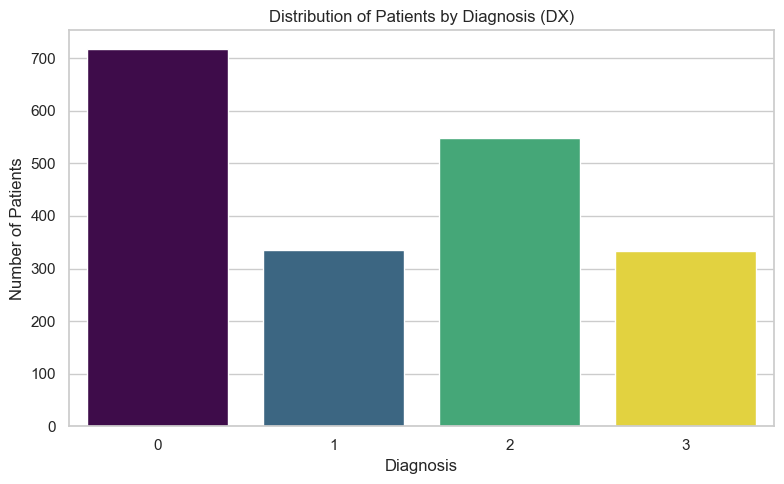

In [2]:
viz = Visualizer(train)
viz.count_plot(
    x="DX",
    figsize=(8, 5),
    palette="viridis",
    order = [0, 1, 2, 3],
    xlabel="Diagnosis",
    ylabel="Number of Patients",
    title="Distribution of Patients by Diagnosis (DX)"
)

We already see that: 
- CN:   717 -> 37.07%
- EMCI: 336 -> 17.37%
- LMCI: 548 -> 28.34%
- AD:   333 -> 17.22%

In [3]:
# Target column
y_train = train['DX']

# All other columns as features
X_train = train.drop(columns=['DX'])

## Explainability Functions

In [4]:
# For XAI Classification
import os
import joblib
import numpy as np

from sklearn.tree import export_text, export_graphviz, plot_tree
import matplotlib.pyplot as plt
import graphviz

def save_xai_models(X_train, y_train, models_dir="../results/all_models"):
    """
    Load models from models_dir and save XAI outputs (tree images and rules)
    into structured folders relative to the parent of models_dir.
    """
    # Determine parent directory of models_dir
    parent_dir = os.path.abspath(os.path.join(models_dir, os.pardir))

    # Base directories for tree images and rules (algorithm-level subfolders only)
    trees_base = os.path.join(parent_dir, "trees")
    rules_base = os.path.join(parent_dir, "rules")

    # Ensure directories exist
    for d in (trees_base, rules_base):
        os.makedirs(d, exist_ok=True)

    # Prepare mapping to collect outputs
    outputs = {}

    # Helper: get feature names (works if X_train is DataFrame or ndarray)
    if hasattr(X_train, "columns"):
        feature_names = list(X_train.columns)
    else:
        # If no column names (e.g. numpy array), create generic names
        ncols = X_train.shape[1]
        feature_names = [f"f{i}" for i in range(ncols)]

    # Load models from models_dir
    models = []
    if not os.path.isdir(models_dir):
        raise FileNotFoundError(f"models_dir not found: {models_dir}")

    for fname in os.listdir(models_dir):
        if fname.endswith(".joblib"):
            model_path = os.path.join(models_dir, fname)
            try:
                model = joblib.load(model_path)
            except Exception as e:
                print(f"Could not load {fname}: {e}")
                continue
            model_name = os.path.splitext(fname)[0]
            models.append((model_name, model))

    print(f"Found {len(models)} models:", [name for name, _ in models])

    # Process each model and save appropriate XAI artifacts
    for model_name, model in models:
        print(f"Processing model: {model_name}")
        outputs[model_name] = {"rules": None, "tree_image": None, "notes": []}

        # Decide model type:
        # 1) OptimalTree -> class name contains "Optimal"
        # 2) DecisionTree-like -> has attribute tree_
        model_cls_name = model.__class__.__name__ if hasattr(model, "__class__") else ""
        is_optimal = "Optimal" in model_cls_name
        is_tree = hasattr(model, "tree_")

        # --- Decision tree / Optimal tree: save textual rules and tree pdf ---
        if is_tree or is_optimal:
            # Choose folder based on whether "Optimal" appears in class name
            if is_optimal:
                rules_dir = rules_base
                tree_dir = trees_base
                outputs[model_name]["notes"].append("Detected as OptimalTree (by class name).")
            else:
                rules_dir = rules_base
                tree_dir = trees_base
                outputs[model_name]["notes"].append("Detected as DecisionTree-like (has tree_).")

            # Save textual rules using sklearn.export_text (IF...THEN style formatting)
            try:
                rules_text = export_text(model, feature_names=feature_names)
                rules_text_ifthen = []
                for line in rules_text.splitlines():
                    stripped = line.lstrip()
                    indent_level = (len(line) - len(stripped)) // 4  # approximate indent
                    if stripped.startswith("|---"):
                        condition = stripped.replace("|---", "").strip()
                        rules_text_ifthen.append("    " * indent_level + "IF " + condition)
                    else:
                        rules_text_ifthen.append("    " * indent_level + stripped.replace("class:", "THEN class ="))
                rules_text = "\n".join(rules_text_ifthen)

                rules_path = os.path.join(rules_dir, f"{model_name}_rules.txt")
                with open(rules_path, "w", encoding="utf-8") as f:
                    f.write(rules_text)
                outputs[model_name]["rules"] = rules_path
            except Exception as e:
                outputs[model_name]["notes"].append(f"Failed to export text rules: {e}")
                print(f"Failed to export text rules for {model_name}: {e}")

            # Save tree diagram as pdf using Graphviz (export_graphviz -> graph.render)
            try:
                class_names = None
                if hasattr(model, "classes_"):
                    try:
                        class_names = [str(c) for c in model.classes_]
                    except Exception:
                        class_names = None

                dot_data = export_graphviz(
                    model,
                    out_file=None,
                    feature_names=feature_names,
                    class_names=class_names,
                    filled=True,
                    rounded=True,
                    special_characters=True
                )

                # Use graphviz.Source and tweak graph/node attributes to reduce overlap
                outbase = os.path.join(tree_dir, f"{model_name}_tree")
                graph = graphviz.Source(dot_data)

                # Improve spacing: nodesep increases horizontal separation, ranksep increases vertical separation
                # margin adds white space around the graph; dpi makes text sharper when rendering to pdf
                graph.graph_attr.update({
                    'nodesep': '0.6',
                    'ranksep': '0.8',
                    'margin': '0.2',
                    'dpi': '300'
                })
                graph.node_attr.update({
                    'fontsize': '8',
                    'shape': 'box',
                    'margin': '0.08'
                })
                graph.edge_attr.update({'fontsize': '8'})

                # Render to pdf
                rendered_path = graph.render(outbase, format='pdf', cleanup=True)
                outputs[model_name]["tree_image"] = rendered_path

            except Exception as e_graphviz:
                # If Graphviz rendering fails, fallback to sklearn.plot_tree + matplotlib with automatic sizing
                outputs[model_name]["notes"].append(f"Graphviz rendering failed: {e_graphviz}. Falling back to matplotlib plot.")
                try:
                    # Determine structural properties to size the figure
                    try:
                        depth = model.get_depth()
                    except Exception:
                        depth = 10
                    try:
                        n_leaves = model.get_n_leaves()
                    except Exception:
                        n_leaves = 10

                    # Choose figure size: width ~ depth, height ~ n_leaves (clamped)
                    fig_w = max(12, depth * 1.5)
                    fig_h = max(6, min(n_leaves * 0.5, 40))  # avoid absurdly tall images
                    out_png = os.path.join(tree_dir, f"{model_name}_tree.pdf")

                    # Temporarily reduce global font size to make nodes smaller if needed
                    prev_fontsize = plt.rcParams.get('font.size', 12)
                    plt.rcParams['font.size'] = 8

                    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
                    # plot_tree will use the axis and respect figure size; rounded + filled helps readability
                    plot_tree(model, feature_names=feature_names,
                              class_names=(class_names if class_names else None),
                              filled=True, rounded=True, proportion=False, ax=ax)
                    plt.tight_layout()
                    fig.savefig(out_png, bbox_inches='tight', dpi=200)
                    plt.close(fig)

                    # restore font size
                    plt.rcParams['font.size'] = prev_fontsize

                    outputs[model_name]["tree_image"] = out_png
                except Exception as e2:
                    outputs[model_name]["notes"].append(f"Failed to render tree pdf fallback: {e2}")
                    # As a last resort, save any dot_data available so user can render later
                    try:
                        fallback_dot_path = os.path.join(tree_dir, f"{model_name}_tree.dot")
                        with open(fallback_dot_path, "w", encoding="utf-8") as f:
                            f.write(dot_data if 'dot_data' in locals() else "/* no dot data */")
                        outputs[model_name]["tree_image"] = fallback_dot_path
                        outputs[model_name]["notes"].append("Saved DOT as fallback.")
                    except Exception as e3:
                        outputs[model_name]["notes"].append(f"Failed to save DOT fallback: {e3}")
                        print(f"Failed to render/save tree for {model_name}: {e_graphviz}; fallback error: {e2}; dot fallback error: {e3}")

        else:
            outputs[model_name]["notes"].append("Model type not recognized for XAI export.")
            print(f"Model {model_name} not recognized as DecisionTree/OptimalTree.")

    print("XAI outputs saved.")

## Build Dataset with Hybrid Sampling

In [5]:
print("Original class distribution (count):")
print(y_train.value_counts())
print("\nOriginal class distribution (percentages):")
print((y_train.value_counts(normalize=True) * 100).round(2))

Original class distribution (count):
DX
0    717
2    548
1    336
3    333
Name: count, dtype: int64

Original class distribution (percentages):
DX
0    37.07
2    28.34
1    17.37
3    17.22
Name: proportion, dtype: float64


In [6]:
counts = y_train.value_counts().to_dict()
n_classes = len(counts)
total = sum(counts.values())

target_count = int(round(total / n_classes))
print(f"\nTarget count per class: {target_count} (total {total} / {n_classes})")



Target count per class: 484 (total 1934 / 4)


In [7]:
# Oversampling strategy: only for classes smaller than target_count
# oversample_dict = {cls: target_count for cls, c in counts.items() if c < target_count}
oversample_dict = {1: 500, 3: 500}

# Undersampling strategy: only for classes larger than target_count
# undersample_dict = {cls: target_count for cls, c in counts.items() if c > target_count}
undersample_dict = {0: 500, 2: 500}

categorical_features = [
    X_train.columns.get_loc("PTGENDER"),
    X_train.columns.get_loc("APOE4")
]

print("\nOversample dict (SMOTENC) -> classes to increase:")
print(oversample_dict)
print("\nUndersample dict (RUS) -> classes to reduce:")
print(undersample_dict)


Oversample dict (SMOTENC) -> classes to increase:
{1: 500, 3: 500}

Undersample dict (RUS) -> classes to reduce:
{0: 500, 2: 500}


In [8]:
steps = []
if oversample_dict:
    smotenc = SMOTENC(
        categorical_features=categorical_features,
        sampling_strategy=oversample_dict,
        random_state=42
    )
    steps.append(('smotenc', smotenc))

if undersample_dict:
    rus = RandomUnderSampler(
        sampling_strategy=undersample_dict,
        random_state=42
    )
    steps.append(('rus', rus))

if not steps:
    print("No resampling needed (all classes already balanced).")
    X_res, y_res = X_train.copy(), y_train.copy()
else:
    pipeline = Pipeline(steps=steps)
    X_res, y_res = pipeline.fit_resample(X_train, y_train)

# Distribution after resampling
print("\nClass distribution after resampling (count):")
print(pd.Series(y_res).value_counts().sort_index())
print("\nClass distribution after resampling (percentages):")
print((pd.Series(y_res).value_counts(normalize=True) * 100).round(2))
X_res.describe().T


Class distribution after resampling (count):
DX
0    500
1    500
2    500
3    500
Name: count, dtype: int64

Class distribution after resampling (percentages):
DX
0    25.0
1    25.0
2    25.0
3    25.0
Name: proportion, dtype: float64


count        mean        std        min        25%  \
AGE                    2000.0   72.623000   7.311813  52.000000  68.000000   
PTGENDER               2000.0    0.550500   0.497568   0.000000   0.000000   
PTEDUCAT               2000.0   15.890500   2.707060   4.000000  14.000000   
APOE4                  2000.0    0.585000   0.662567   0.000000   0.000000   
MMSE                   2000.0   26.884000   2.857206  16.000000  25.000000   
CDRSB                  2000.0    1.835129   1.864356   0.000000   0.500000   
ADAS13                 2000.0   17.359500   9.926254   0.000000  10.000000   
LDELTOTAL              2000.0    6.852500   5.229954   0.000000   2.000000   
FAQ                    2000.0    4.719000   6.473947   0.000000   0.000000   
MOCA                   2000.0   22.157000   4.365992   4.000000  20.000000   
TRABSCOR               2000.0  127.389000  79.294076  21.000000  69.000000   
RAVLT_immediate        2000.0   34.755000  12.542513   0.000000  25.000000   
RAVLT_learning         2000.0    4.102000   2.750341  -4.000000   2.000000   
RAVLT_perc_forgetting  2000.0   60.580245  34.459432 -50.000000  30.769200   
mPACCdigit             2000.0   -6.576068   6.446037 -23.603400 -11.528200   
EcogPtMem              2000.0    2.169633   0.635912   1.000000   1.725000   
EcogPtLang             2000.0    1.790775   0.576944   1.000000   1.333330   
EcogPtVisspat          2000.0    1.442276   0.494437   1.000000   1.085714   
EcogPtPlan             2000.0    1.461841   0.503352   1.000000   1.000000   
EcogPtOrgan            2000.0    1.549754   0.542485   1.000000   1.166670   
EcogPtDivatt           2000.0    1.844796   0.659102   1.000000   1.350000   
EcogSPMem              2000.0    2.261278   0.892913   1.000000   1.466572   
EcogSPLang             2000.0    1.738137   0.705452   1.000000   1.111110   
EcogSPVisspat          2000.0    1.600544   0.714626   1.000000   1.000000   
EcogSPPlan             2000.0    1.710374   0.771754   1.000000   1.000000   
EcogSPOrgan            2000.0    1.822962   0.839062   1.000000   1.033334   
EcogSPDivatt           2000.0    2.031092   0.885282   1.000000   1.250000   
FDG                    2000.0    1.192916   0.150314   0.647497   1.097850   
PTAU/ABETA             2000.0    0.038204   0.027742   0.006020   0.016581   
Hippocampus/ICV        2000.0    0.004499   0.000826   0.001998   0.003883   
Entorhinal/ICV         2000.0    0.002349   0.000552   0.000926   0.001958   
Fusiform/ICV           2000.0    0.011480   0.001714   0.005934   0.010303   
MidTemp/ICV            2000.0    0.012849   0.001860   0.006737   0.011526   
Ventricles/ICV         2000.0    0.026428   0.012548   0.004600   0.017072   
WholeBrain/ICV         2000.0    0.677120   0.052363   0.507694   0.638664   

                             50%         75%         max  
AGE                    73.000000   78.000000   90.000000  
PTGENDER                1.000000    1.000000    1.000000  
PTEDUCAT               16.000000   18.000000   20.000000  
APOE4                   0.000000    1.000000    2.000000  
MMSE                   28.000000   29.000000   30.000000  
CDRSB                   1.495481    3.000000   10.000000  
ADAS13                 15.000000   24.000000   56.000000  
LDELTOTAL               7.000000   10.000000   22.000000  
FAQ                     1.000000    8.000000   30.000000  
MOCA                   23.000000   25.000000   30.000000  
TRABSCOR               97.000000  162.250000  300.000000  
RAVLT_immediate        34.000000   43.000000   71.000000  
RAVLT_learning          4.000000    6.000000   12.000000  
RAVLT_perc_forgetting  61.237736  100.000000  100.000000  
mPACCdigit             -5.484310   -1.418535    6.300310  
EcogPtMem               2.125000    2.575000    4.000000  
EcogPtLang              1.699482    2.111110    4.000000  
EcogPtVisspat           1.296055    1.641510    4.000000  
EcogPtPlan              1.360000    1.640000    4.000000  
EcogPtOrgan             1.445868   

The **ADNIClassifier** class was designed as a support tool for training and evaluating different classification models on data derived from the ADNI dataset. Upon initialization, it allows you to choose between different sets of classifiers, which can be traditional models or explainable methods (XAI), already configured with the best hyperparameters found via grid search. The main function, `fit_evaluate_store_models`, takes the training data and, for each classifier, performs a repeated stratified cross-validation (5-fold by default), collects predictions and probabilities, calculates global and class-specific metrics, generates comparison plots and confusion matrices. Finally, it refits each model on the entire training set, saves it to disk, and returns two DataFrames: one with the overall metrics and one with the results by class.

## Dataset with `CDRSB`, `LDELTOTAL`, and `mPACCdigit` with Standard Classification

### No Sampling

Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: XGBoost
Training & Evaluating: LightGBM
Training & Evaluating: CatBoost
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: KNN
Training & Evaluating: Bagging


Model  Accuracy  Balanced Accuracy  \
2                          XGBoost  0.932092           0.921863   
4                         CatBoost  0.928818           0.918172   
1                      Extra Trees  0.928818           0.919840   
3                         LightGBM  0.931748           0.921442   
0                    Random Forest  0.928301           0.917331   
7                          Bagging  0.928645           0.918030   
5  Multinomial Logistic Regression  0.887797           0.881650   
6                              KNN  0.753878           0.693788   

   Precision (weighted)  Recall (weighted)  F1 Score (weighted)  \
2              0.932176           0.932092             0.931935   
4              0.929135           0.928818             0.928688   
1              0.929312           0.928818             0.928880   
3              0.932291           0.931748             0.931478   
0              0.928337           0.928301             0.928041   
7              0.928776           0.928645             0.928497   
5              0.891202           0.887797             0.888457   
6              0.748449           0.753878             0.733027   

   F1 Score (macro)  ROC AUC (macro)  
2          0.921589         0.988434  
4          0.918458         0.987165  
1          0.918871         0.987122  
3          0.921114         0.985813  
0          0.916865         0.984900  
7          0.917857         0.981729  
5          0.873890         0.979621  
6          0.699164         0.925400

Model  Class  Precision    Recall  F1 Score  \
0                     Random Forest      0   0.982605  0.971641  0.977092   
1                     Random Forest      1   0.907547  0.954365  0.930368   
2                     Random Forest      2   0.900955  0.918491  0.909639   
3                     Random Forest      3   0.877529  0.824825  0.850361   
4                       Extra Trees      0   0.982922  0.963273  0.972998   
5                       Extra Trees      1   0.902765  0.939484  0.920758   
6                       Extra Trees      2   0.901902  0.922749  0.912207   
7                       Extra Trees      3   0.885774  0.853854  0.869521   
8                           XGBoost      0   0.982605  0.971641  0.977092   
9                           XGBoost      1   0.913251  0.950397  0.931454   
10                          XGBoost      2   0.906380  0.924574  0.915387   
11                          XGBoost      3   0.885142  0.840841  0.862423   
12                         LightGBM      0   0.983909  0.966527  0.975141   
13                         LightGBM      1   0.900372  0.959325  0.928915   
14                         LightGBM      2   0.902884  0.933090  0.917739   
15                         LightGBM      3   0.901747  0.826827  0.862663   
16                         CatBoost      0   0.981132  0.966992  0.974011   
17                         CatBoost      1   0.909091  0.942460  0.925475   
18                         CatBoost      2   0.896410  0.926399  0.911158   
19                         CatBoost      3   0.891258  0.836837  0.863191   
20  Multinomial Logistic Regression      0   0.978978  0.952580  0.965598   
21  Multinomial Logistic Regression      1   0.785211  0.884921  0.832090   
22  Multinomial Logistic Regression      2   0.875740  0.810219  0.841706   
23  Multinomial Logistic Regression      3   0.834601  0.878879  0.856168   
24                              KNN      0   0.773100  0.964668  0.858325   
25                              KNN      1   0.682759  0.294643  0.411642   
26                              KNN      2   0.693638  0.756083  0.723516   
27                              KNN      3   0.851852  0.759760  0.803175   
28                          Bagging      0   0.981176  0.969317  0.975210   
29                          Bagging      1   0.909351  0.945437  0.927043   
30                          Bagging      2   0.900713  0.921533  0.911004   
31                          Bagging      3   0.881732  0.835836  0.858171   

    Support  
0    2151.0  
1    1008.0  
2    1644.0  
3     999.0  
4    2151.0  
5    1008.0  
6    1644.0  
7     999.0  
8    2151.0  
9    1008.0  
10   1644.0  
11    999.0  
12   2151.0  
13   1008.0  
14   1644.0  
15    999.0  
16   2151.0  
17   1008.0  
18   1644.0  
19    999.0  
20   2151.0  
21   1008.0  
22   1644.0  
23    999.0  
24   2151.0  
25   1008.0  
26   1644.0  
27    999.0  
28   2151.0  
29   1008.0  
30   1644.0  
31    999.0

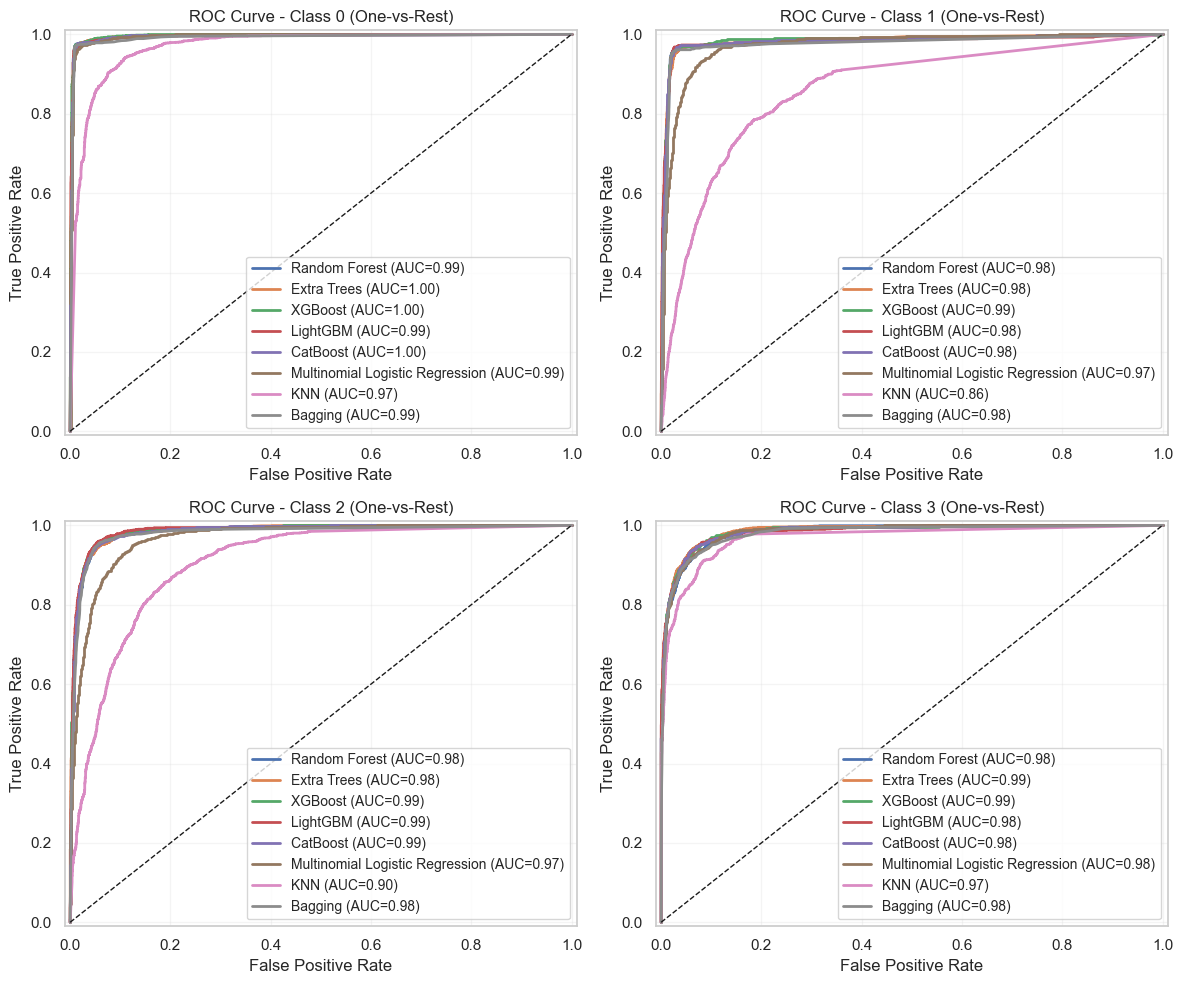

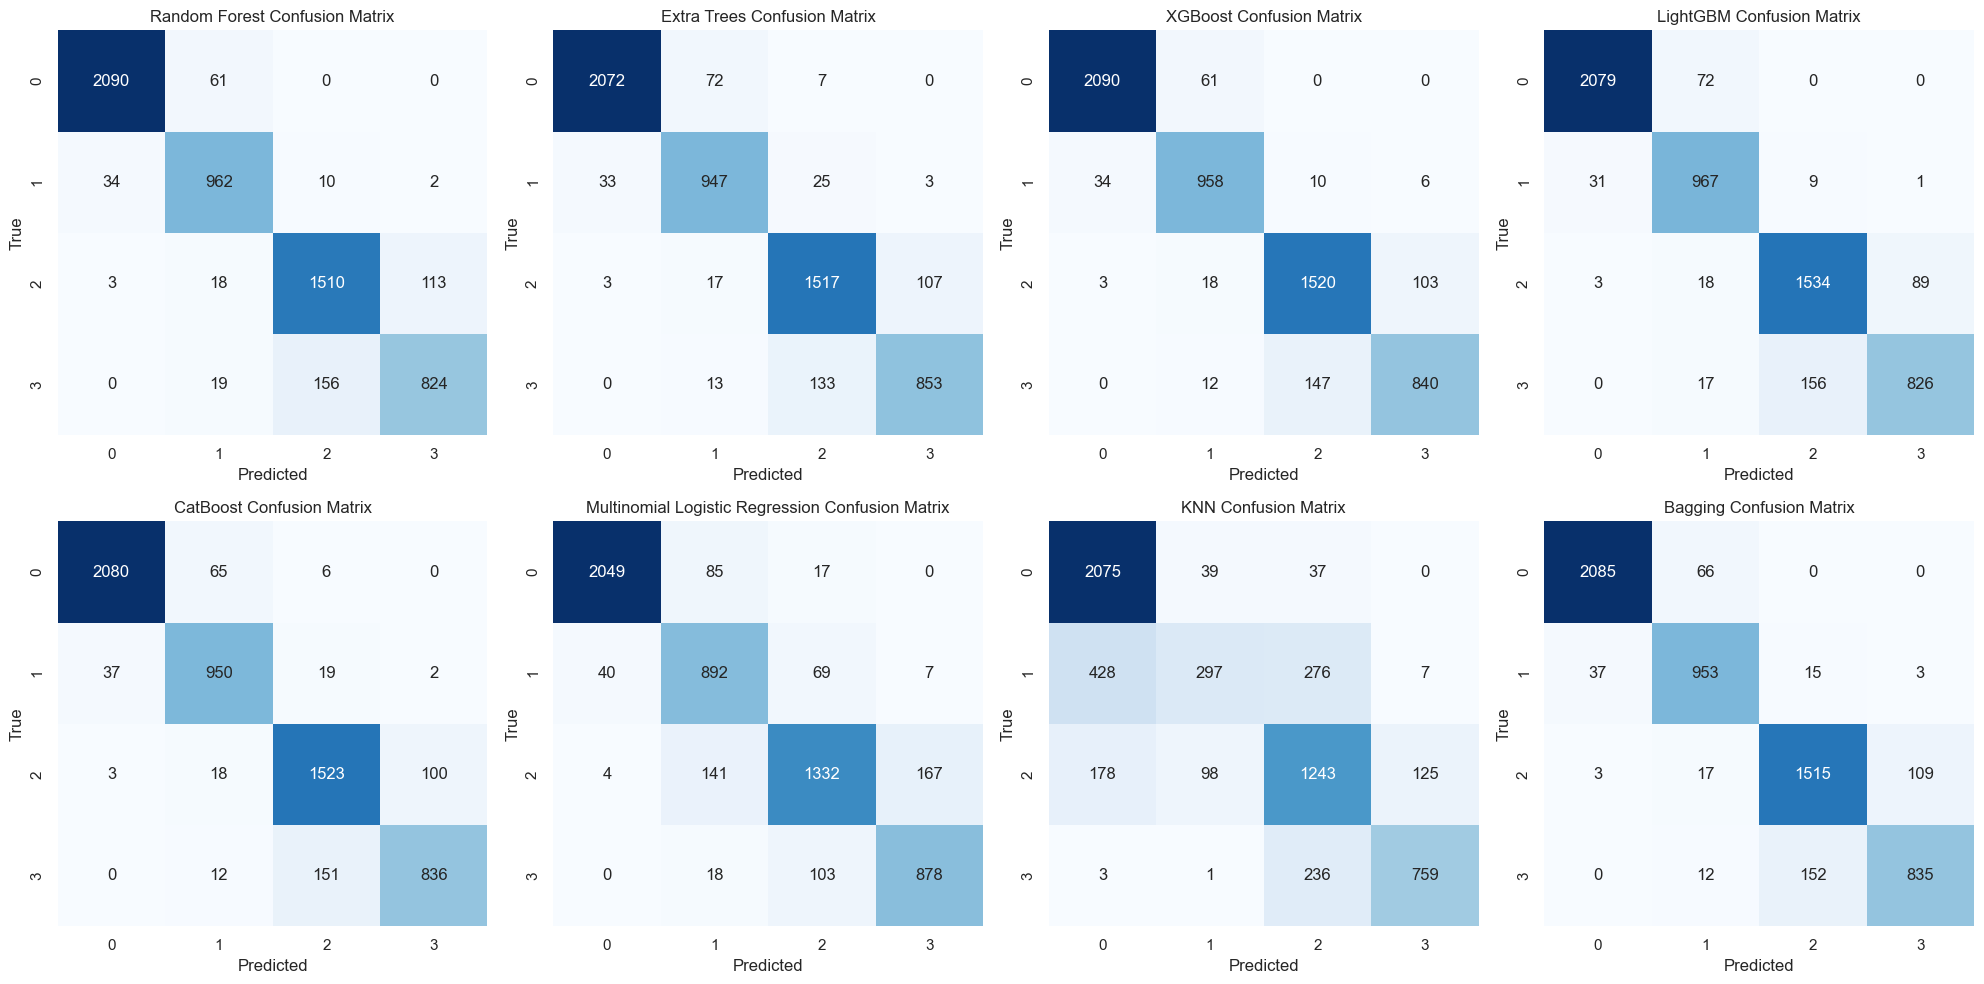

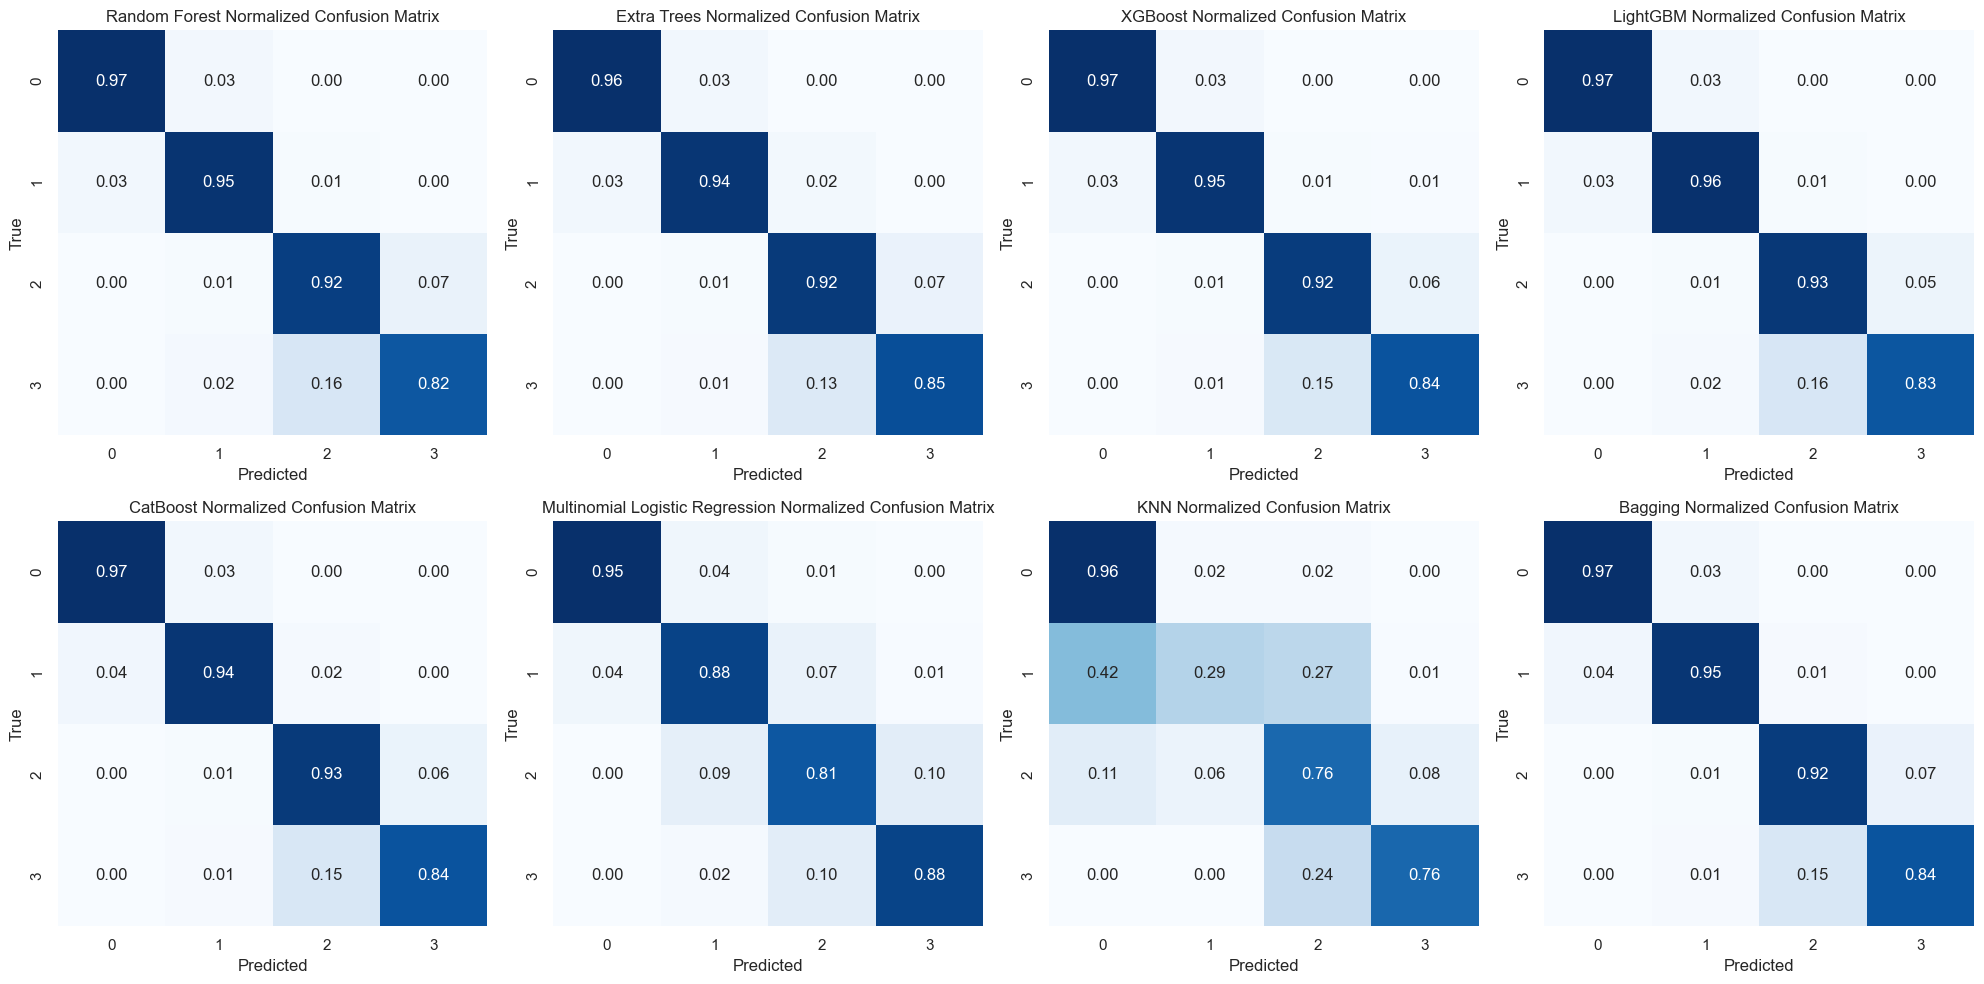

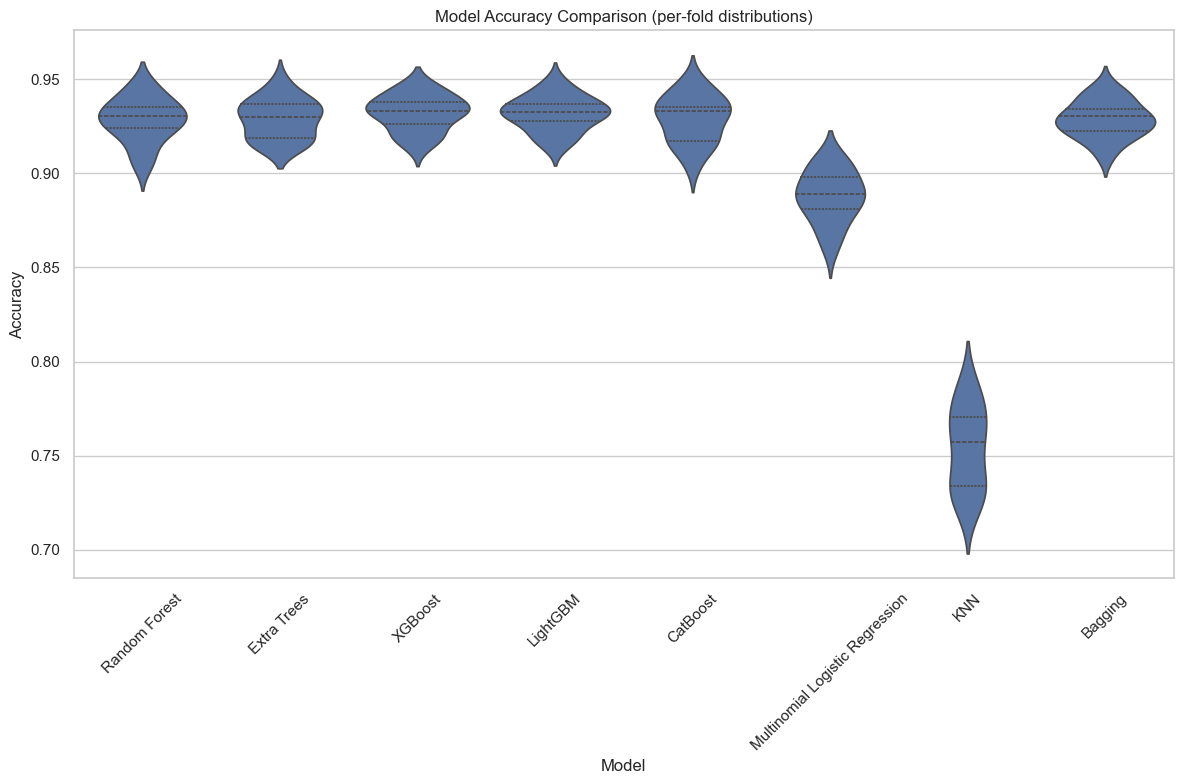

In [9]:
classifier = ADNIClassifier(classifier="Standard1")
result_df_1, per_class_df_1 = classifier.fit_evaluate_store_models(X_train, y_train, output_dir="../results/all_models/1_NX_NS")

#### Choosing the best model

...

### Hybrid Sampling

Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: XGBoost
Training & Evaluating: LightGBM
Training & Evaluating: CatBoost
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: KNN
Training & Evaluating: Bagging


Model  Accuracy  Balanced Accuracy  \
1                      Extra Trees  0.932000           0.932000   
2                          XGBoost  0.934500           0.934500   
4                         CatBoost  0.929333           0.929333   
0                    Random Forest  0.931333           0.931333   
3                         LightGBM  0.929167           0.929167   
7                          Bagging  0.922833           0.922833   
5  Multinomial Logistic Regression  0.887667           0.887667   
6                              KNN  0.795167           0.795167   

   Precision (weighted)  Recall (weighted)  F1 Score (weighted)  \
1              0.932356           0.932000             0.932134   
2              0.934705           0.934500             0.934583   
4              0.929836           0.929333             0.929460   
0              0.931568           0.931333             0.931392   
3              0.929472           0.929167             0.929234   
7              0.923111           0.922833             0.922943   
5              0.887594           0.887667             0.887546   
6              0.791947           0.795167             0.791072   

   F1 Score (macro)  ROC AUC (macro)  
1          0.932134         0.990114  
2          0.934583         0.990086  
4          0.929460         0.989525  
0          0.931392         0.986867  
3          0.929234         0.986659  
7          0.922943         0.983961  
5          0.887546         0.979931  
6          0.791072         0.947915

Model  Class  Precision    Recall  F1 Score  \
0                     Random Forest      0   0.976918  0.959333  0.968046   
1                     Random Forest      1   0.939096  0.956000  0.947473   
2                     Random Forest      2   0.895395  0.907333  0.901325   
3                     Random Forest      3   0.914865  0.902667  0.908725   
4                       Extra Trees      0   0.978172  0.956000  0.966959   
5                       Extra Trees      1   0.940555  0.949333  0.944924   
6                       Extra Trees      2   0.894529  0.904667  0.899569   
7                       Extra Trees      3   0.916168  0.918000  0.917083   
8                           XGBoost      0   0.976303  0.961333  0.968760   
9                           XGBoost      1   0.944371  0.950667  0.947508   
10                          XGBoost      2   0.903974  0.910000  0.906977   
11                          XGBoost      3   0.914172  0.916000  0.915085   
12                         LightGBM      0   0.979494  0.955333  0.967263   
13                         LightGBM      1   0.935631  0.959333  0.947334   
14                         LightGBM      2   0.892999  0.901333  0.897147   
15                         LightGBM      3   0.909764  0.900667  0.905193   
16                         CatBoost      0   0.979972  0.946000  0.962687   
17                         CatBoost      1   0.933117  0.958000  0.945395   
18                         CatBoost      2   0.893939  0.904667  0.899271   
19                         CatBoost      3   0.912316  0.908667  0.910488   
20  Multinomial Logistic Regression      0   0.963062  0.956000  0.959518   
21  Multinomial Logistic Regression      1   0.868778  0.896000  0.882179   
22  Multinomial Logistic Regression      2   0.825939  0.806667  0.816189   
23  Multinomial Logistic Regression      3   0.892595  0.892000  0.892297   
24                              KNN      0   0.818182  0.906000  0.859854   
25                              KNN      1   0.743709  0.748667  0.746179   
26                              KNN      2   0.755899  0.619333  0.680835   
27                              KNN      3   0.850000  0.906667  0.877419   
28                          Bagging      0   0.968919  0.956000  0.962416   
29                          Bagging      1   0.935548  0.938667  0.937105   
30                          Bagging      2   0.883279  0.898000  0.890579   
31                          Bagging      3   0.904698  0.898667  0.901672   

    Support  
0    1500.0  
1    1500.0  
2    1500.0  
3    1500.0  
4    1500.0  
5    1500.0  
6    1500.0  
7    1500.0  
8    1500.0  
9    1500.0  
10   1500.0  
11   1500.0  
12   1500.0  
13   1500.0  
14   1500.0  
15   1500.0  
16   1500.0  
17   1500.0  
18   1500.0  
19   1500.0  
20   1500.0  
21   1500.0  
22   1500.0  
23   1500.0  
24   1500.0  
25   1500.0  
26   1500.0  
27   1500.0  
28   1500.0  
29   1500.0  
30   1500.0  
31   1500.0

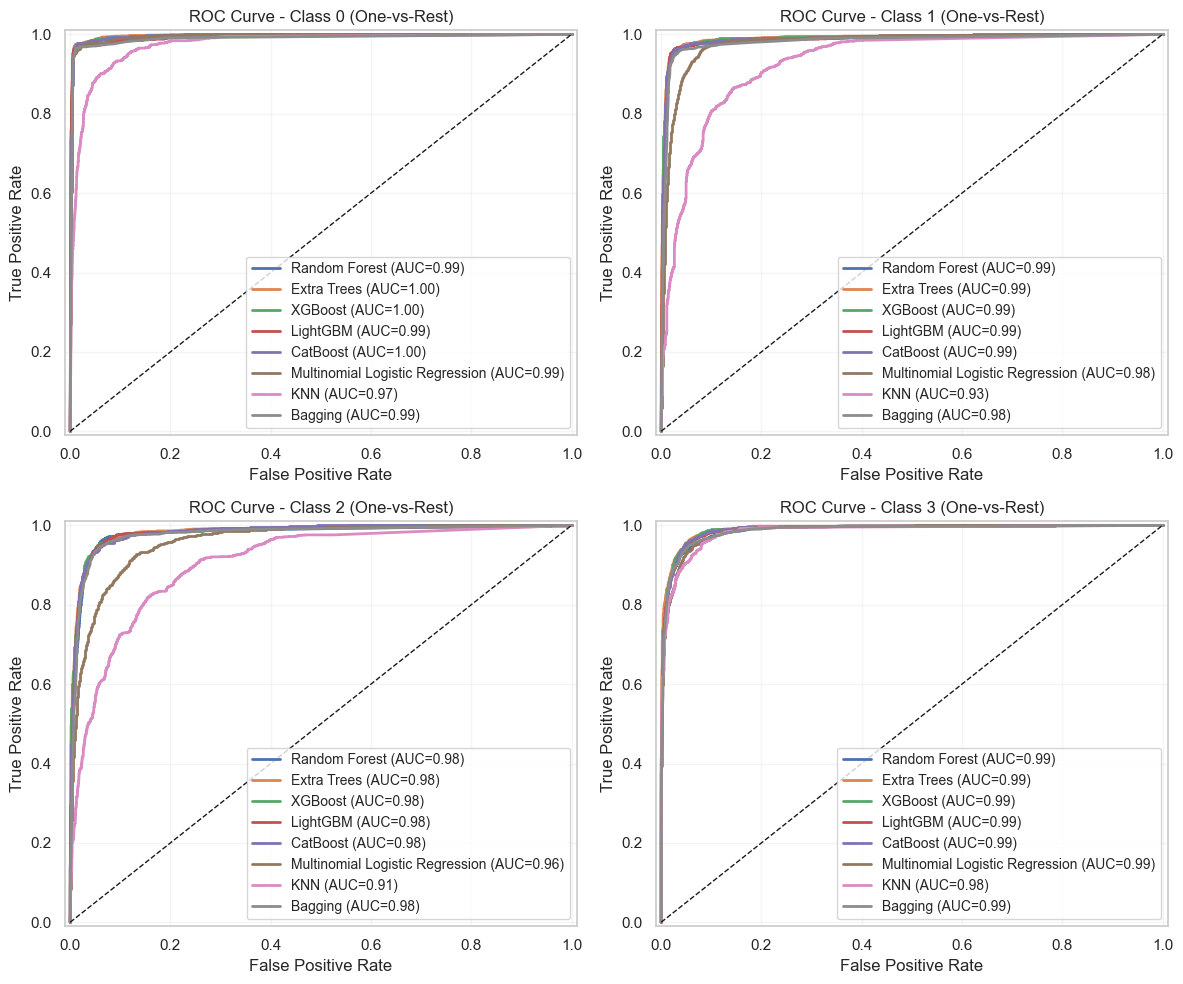

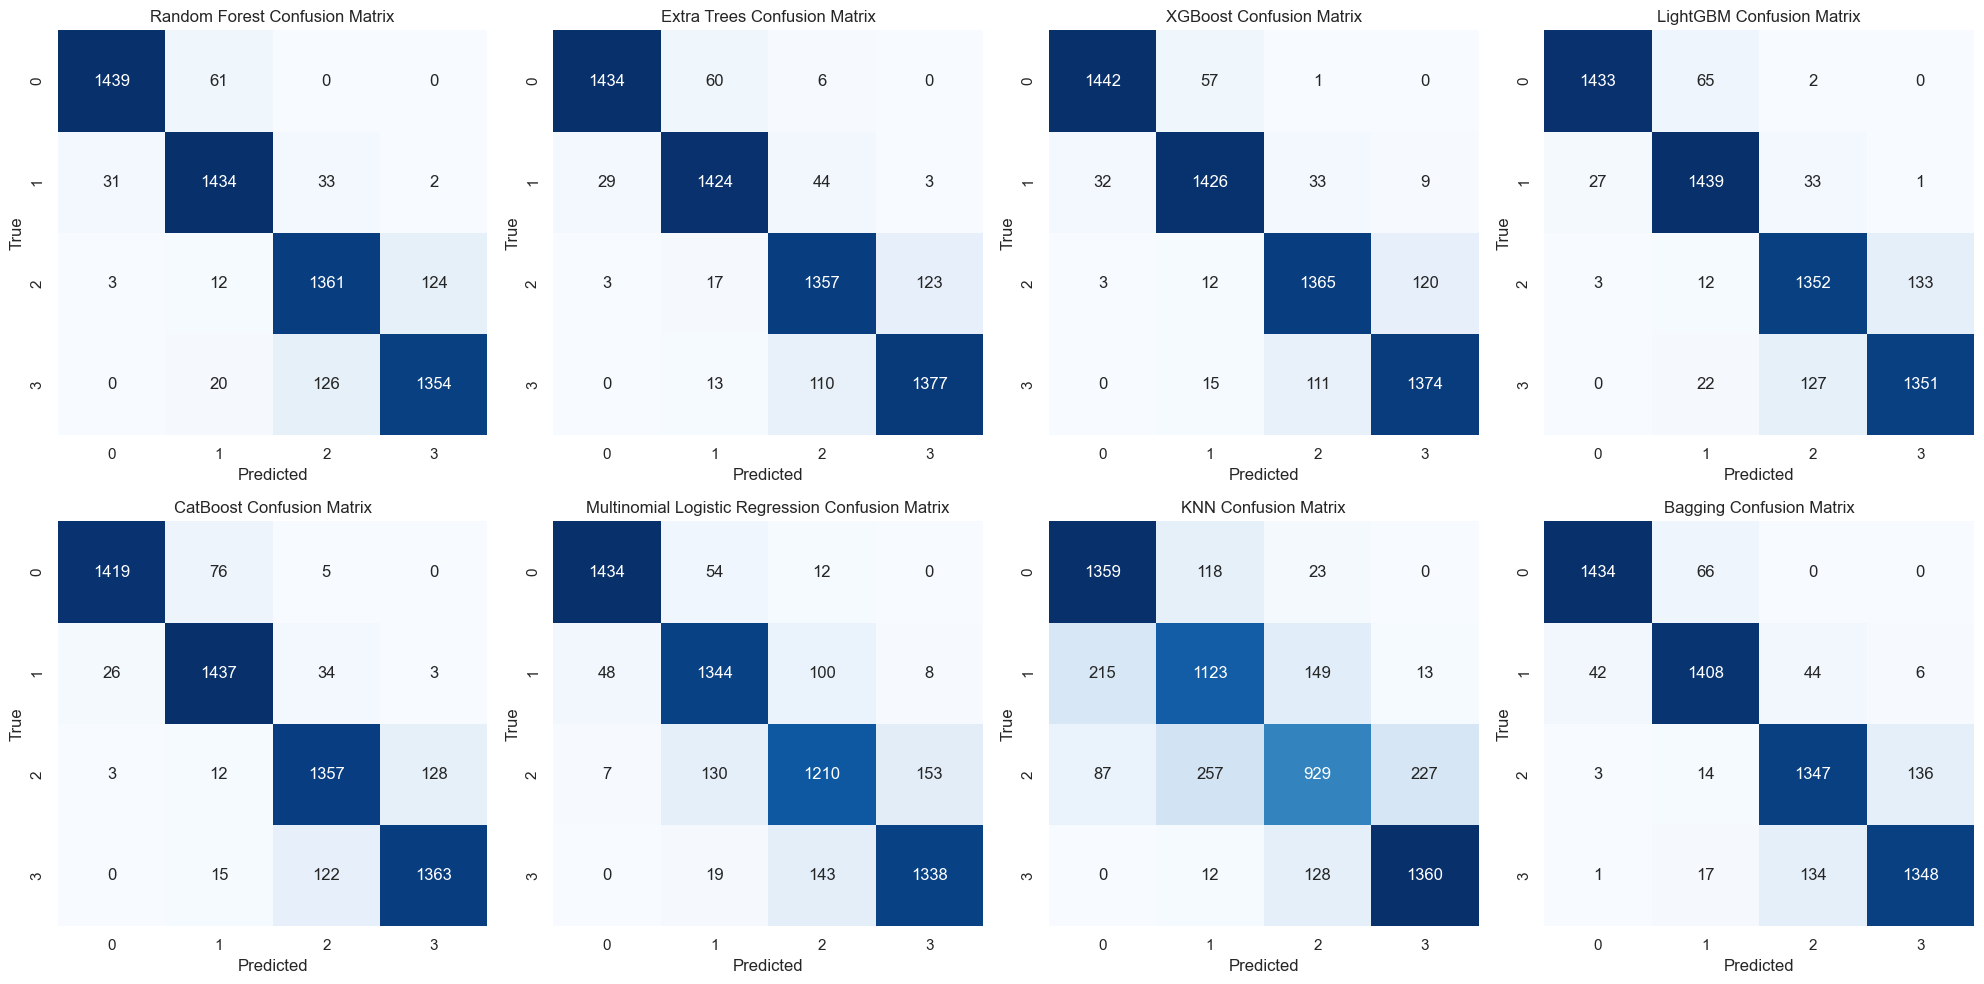

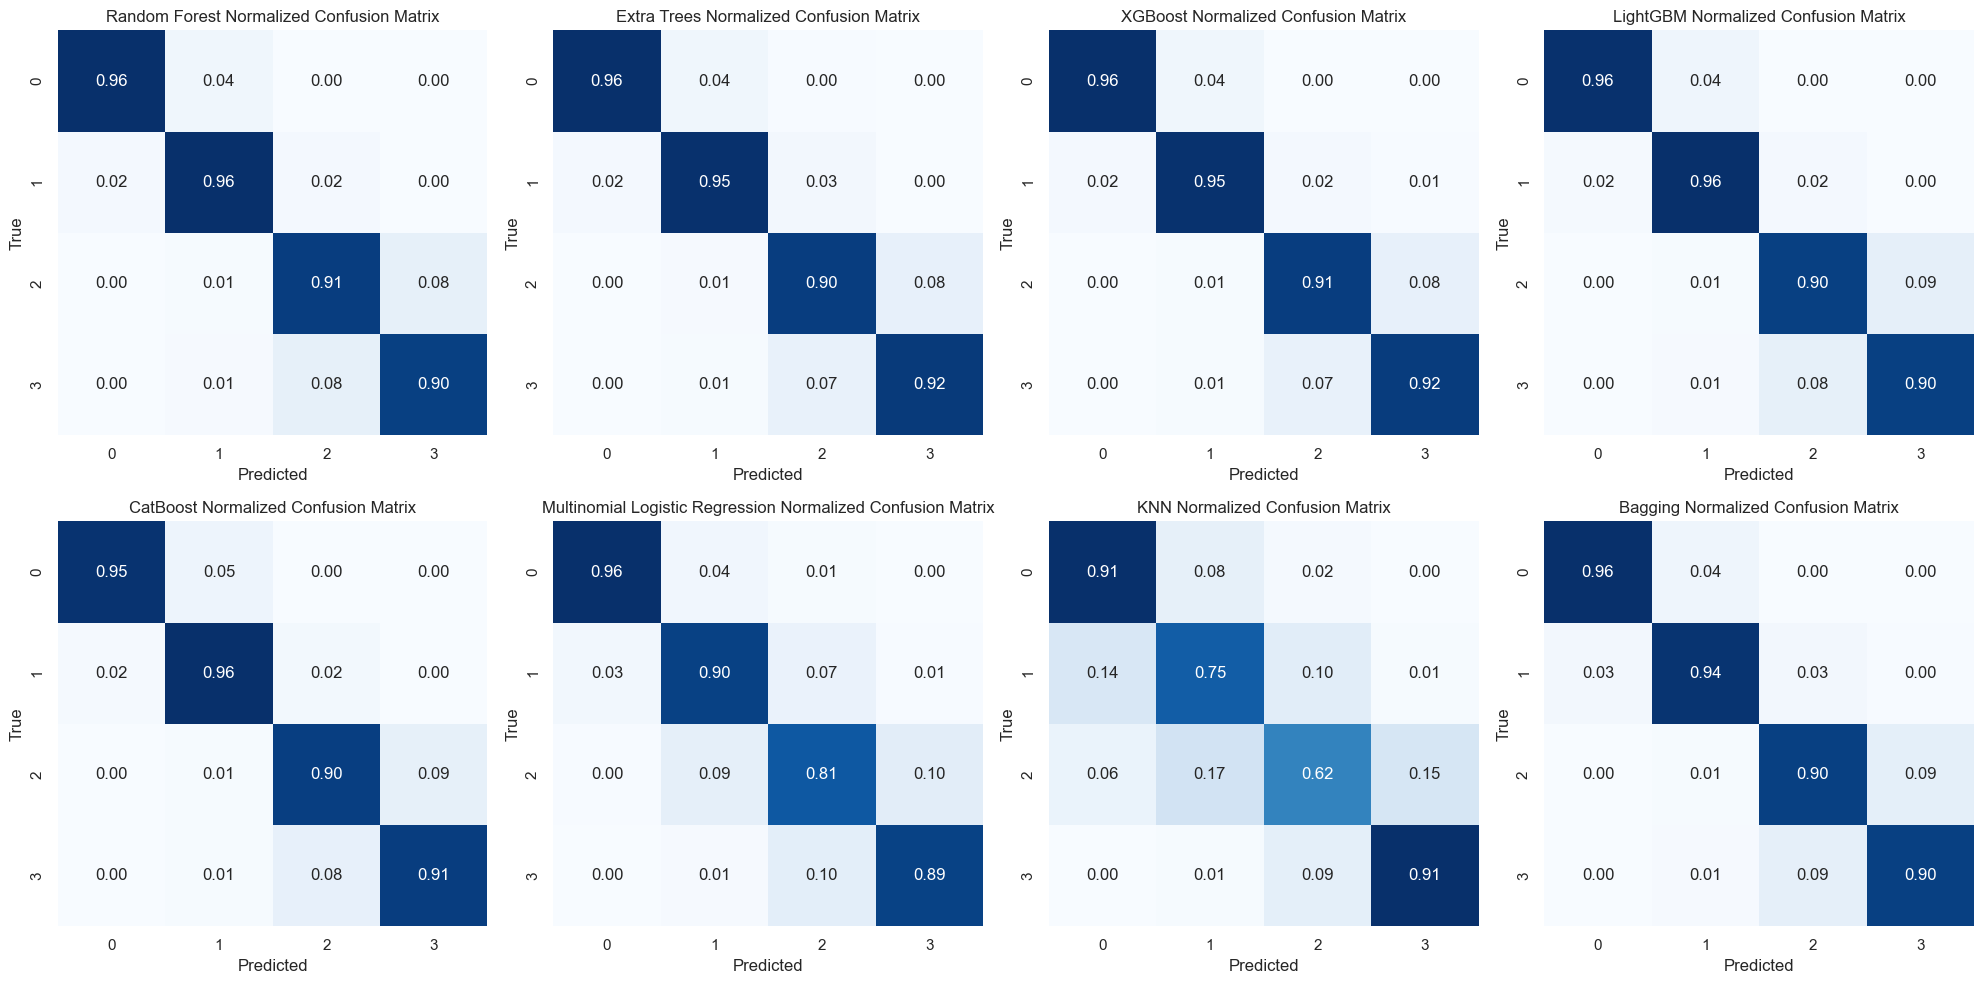

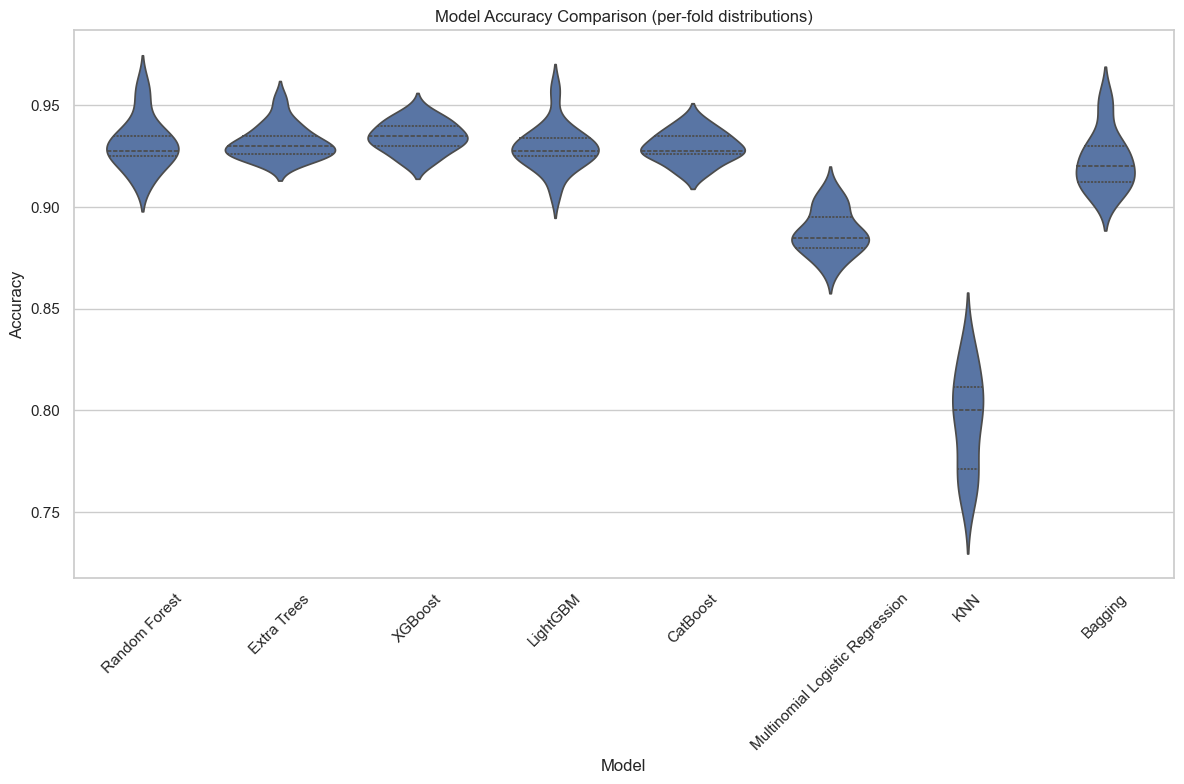

In [10]:
result_df_2, per_class_df_2 = classifier.fit_evaluate_store_models(X_res, y_res, output_dir="../results/all_models/1_NX_S")

#### Choosing the best model

...

## Dataset with `CDRSB`, `LDELTOTAL`, and `mPACCdigit` with XAI Classification

### No Sampling

Training & Evaluating: Decision Tree
Training & Evaluating: OptimalTree


Model  Accuracy  Balanced Accuracy  Precision (weighted)  \
0  Decision Tree  0.909514           0.902432              0.911551   
1    OptimalTree  0.881593           0.865261              0.881671   

   Recall (weighted)  F1 Score (weighted)  F1 Score (macro)  ROC AUC (macro)  
0           0.909514             0.909975          0.896933         0.964918  
1           0.881593             0.881620          0.864802         0.913006

Model  Class  Precision    Recall  F1 Score  Support
0  Decision Tree      0   0.980669  0.966992  0.973783   2151.0
1  Decision Tree      1   0.892148  0.935516  0.913317   1008.0
2  Decision Tree      2   0.904854  0.850365  0.876764   1644.0
3  Decision Tree      3   0.793327  0.856857  0.823869    999.0
4    OptimalTree      0   0.953132  0.954905  0.954018   2151.0
5    OptimalTree      1   0.853610  0.856151  0.854879   1008.0
6    OptimalTree      2   0.861624  0.852190  0.856881   1644.0
7    OptimalTree      3   0.789109  0.797798  0.793430    999.0

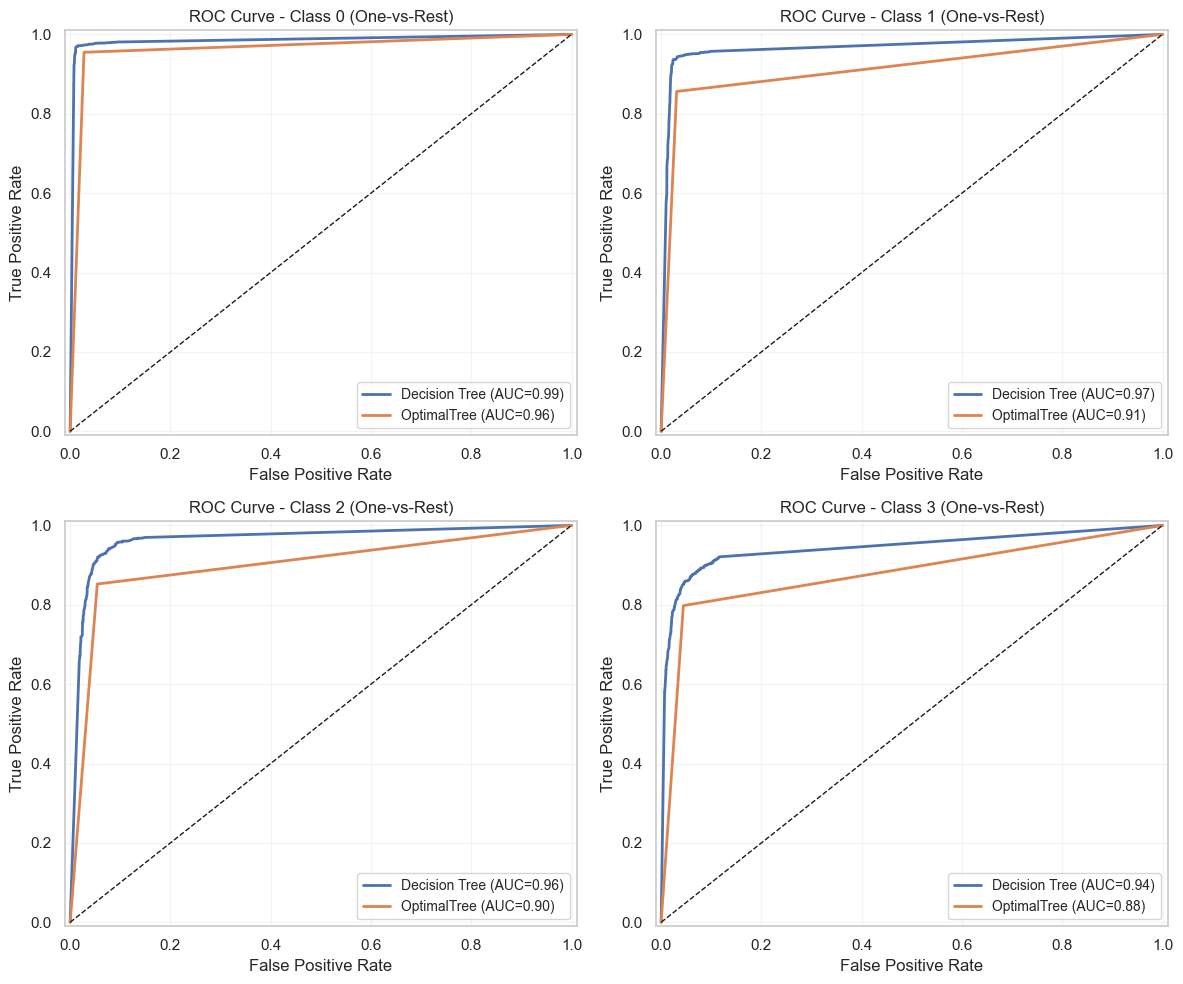

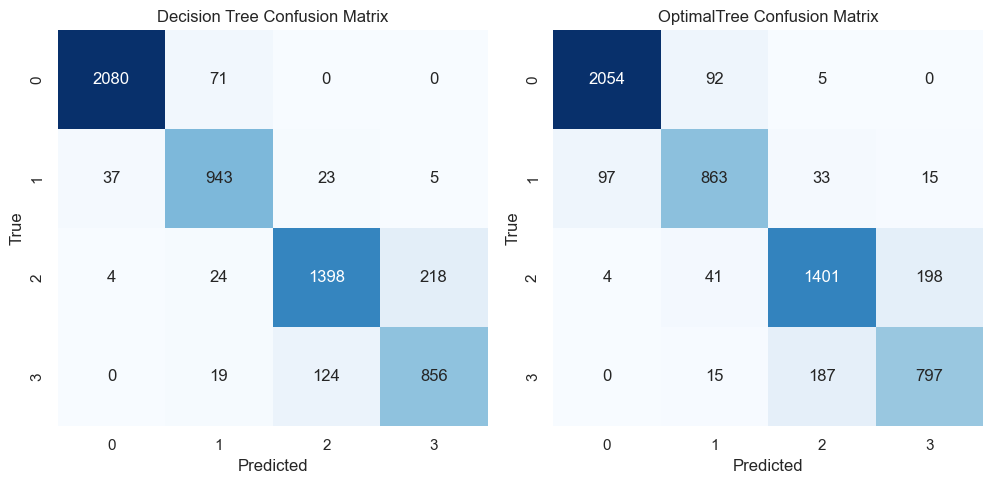

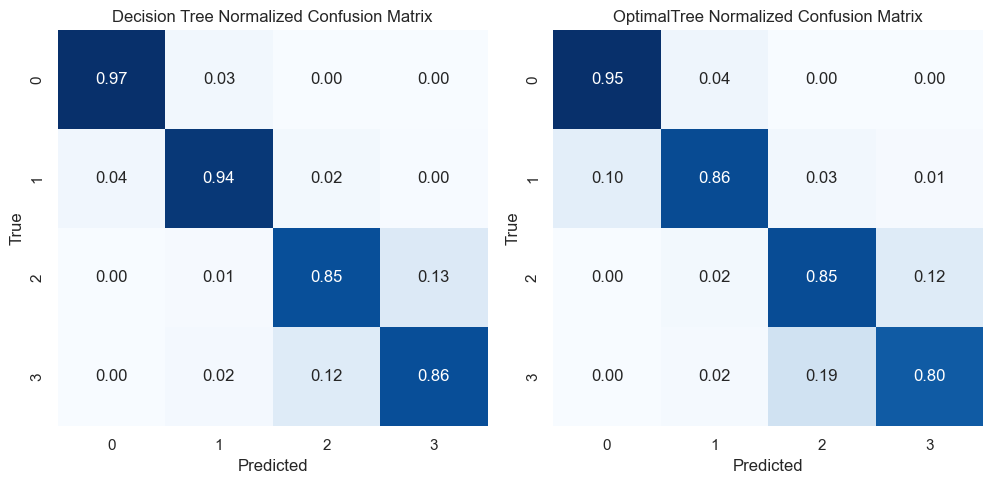

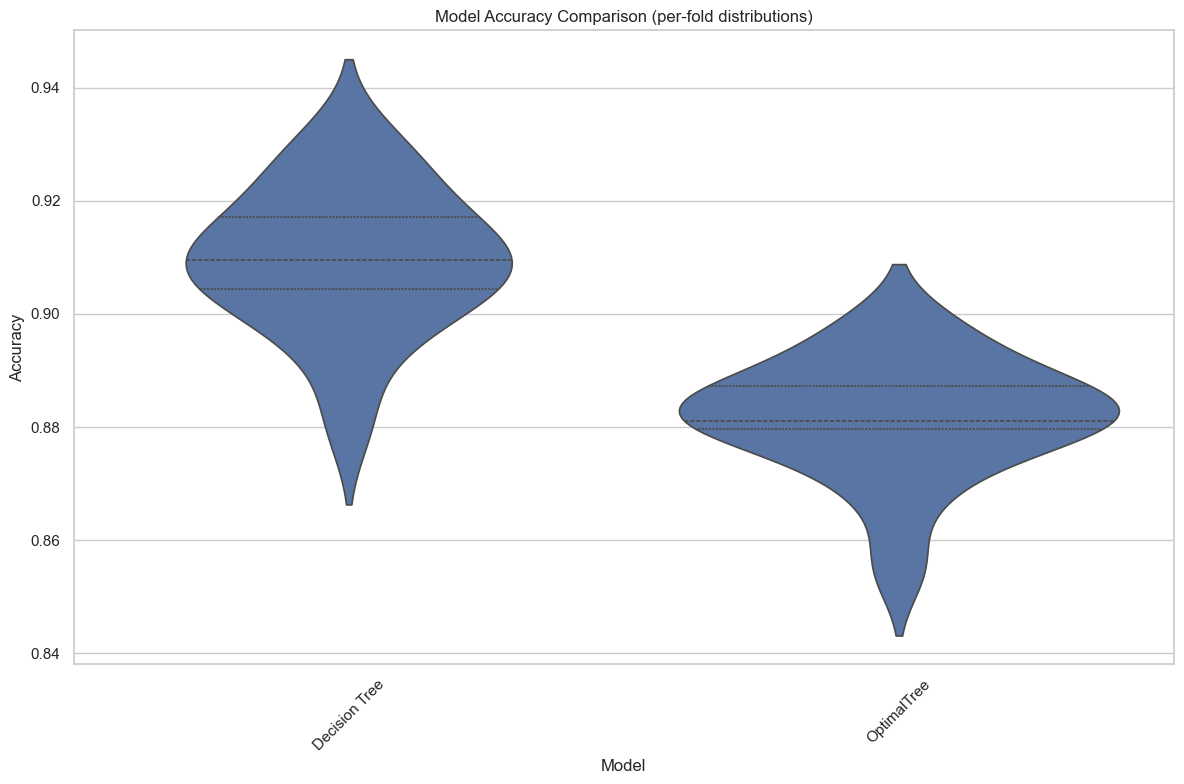

Found 2 models: ['Decision_Tree', 'OptimalTree']
Processing model: Decision_Tree
Processing model: OptimalTree
XAI outputs saved.


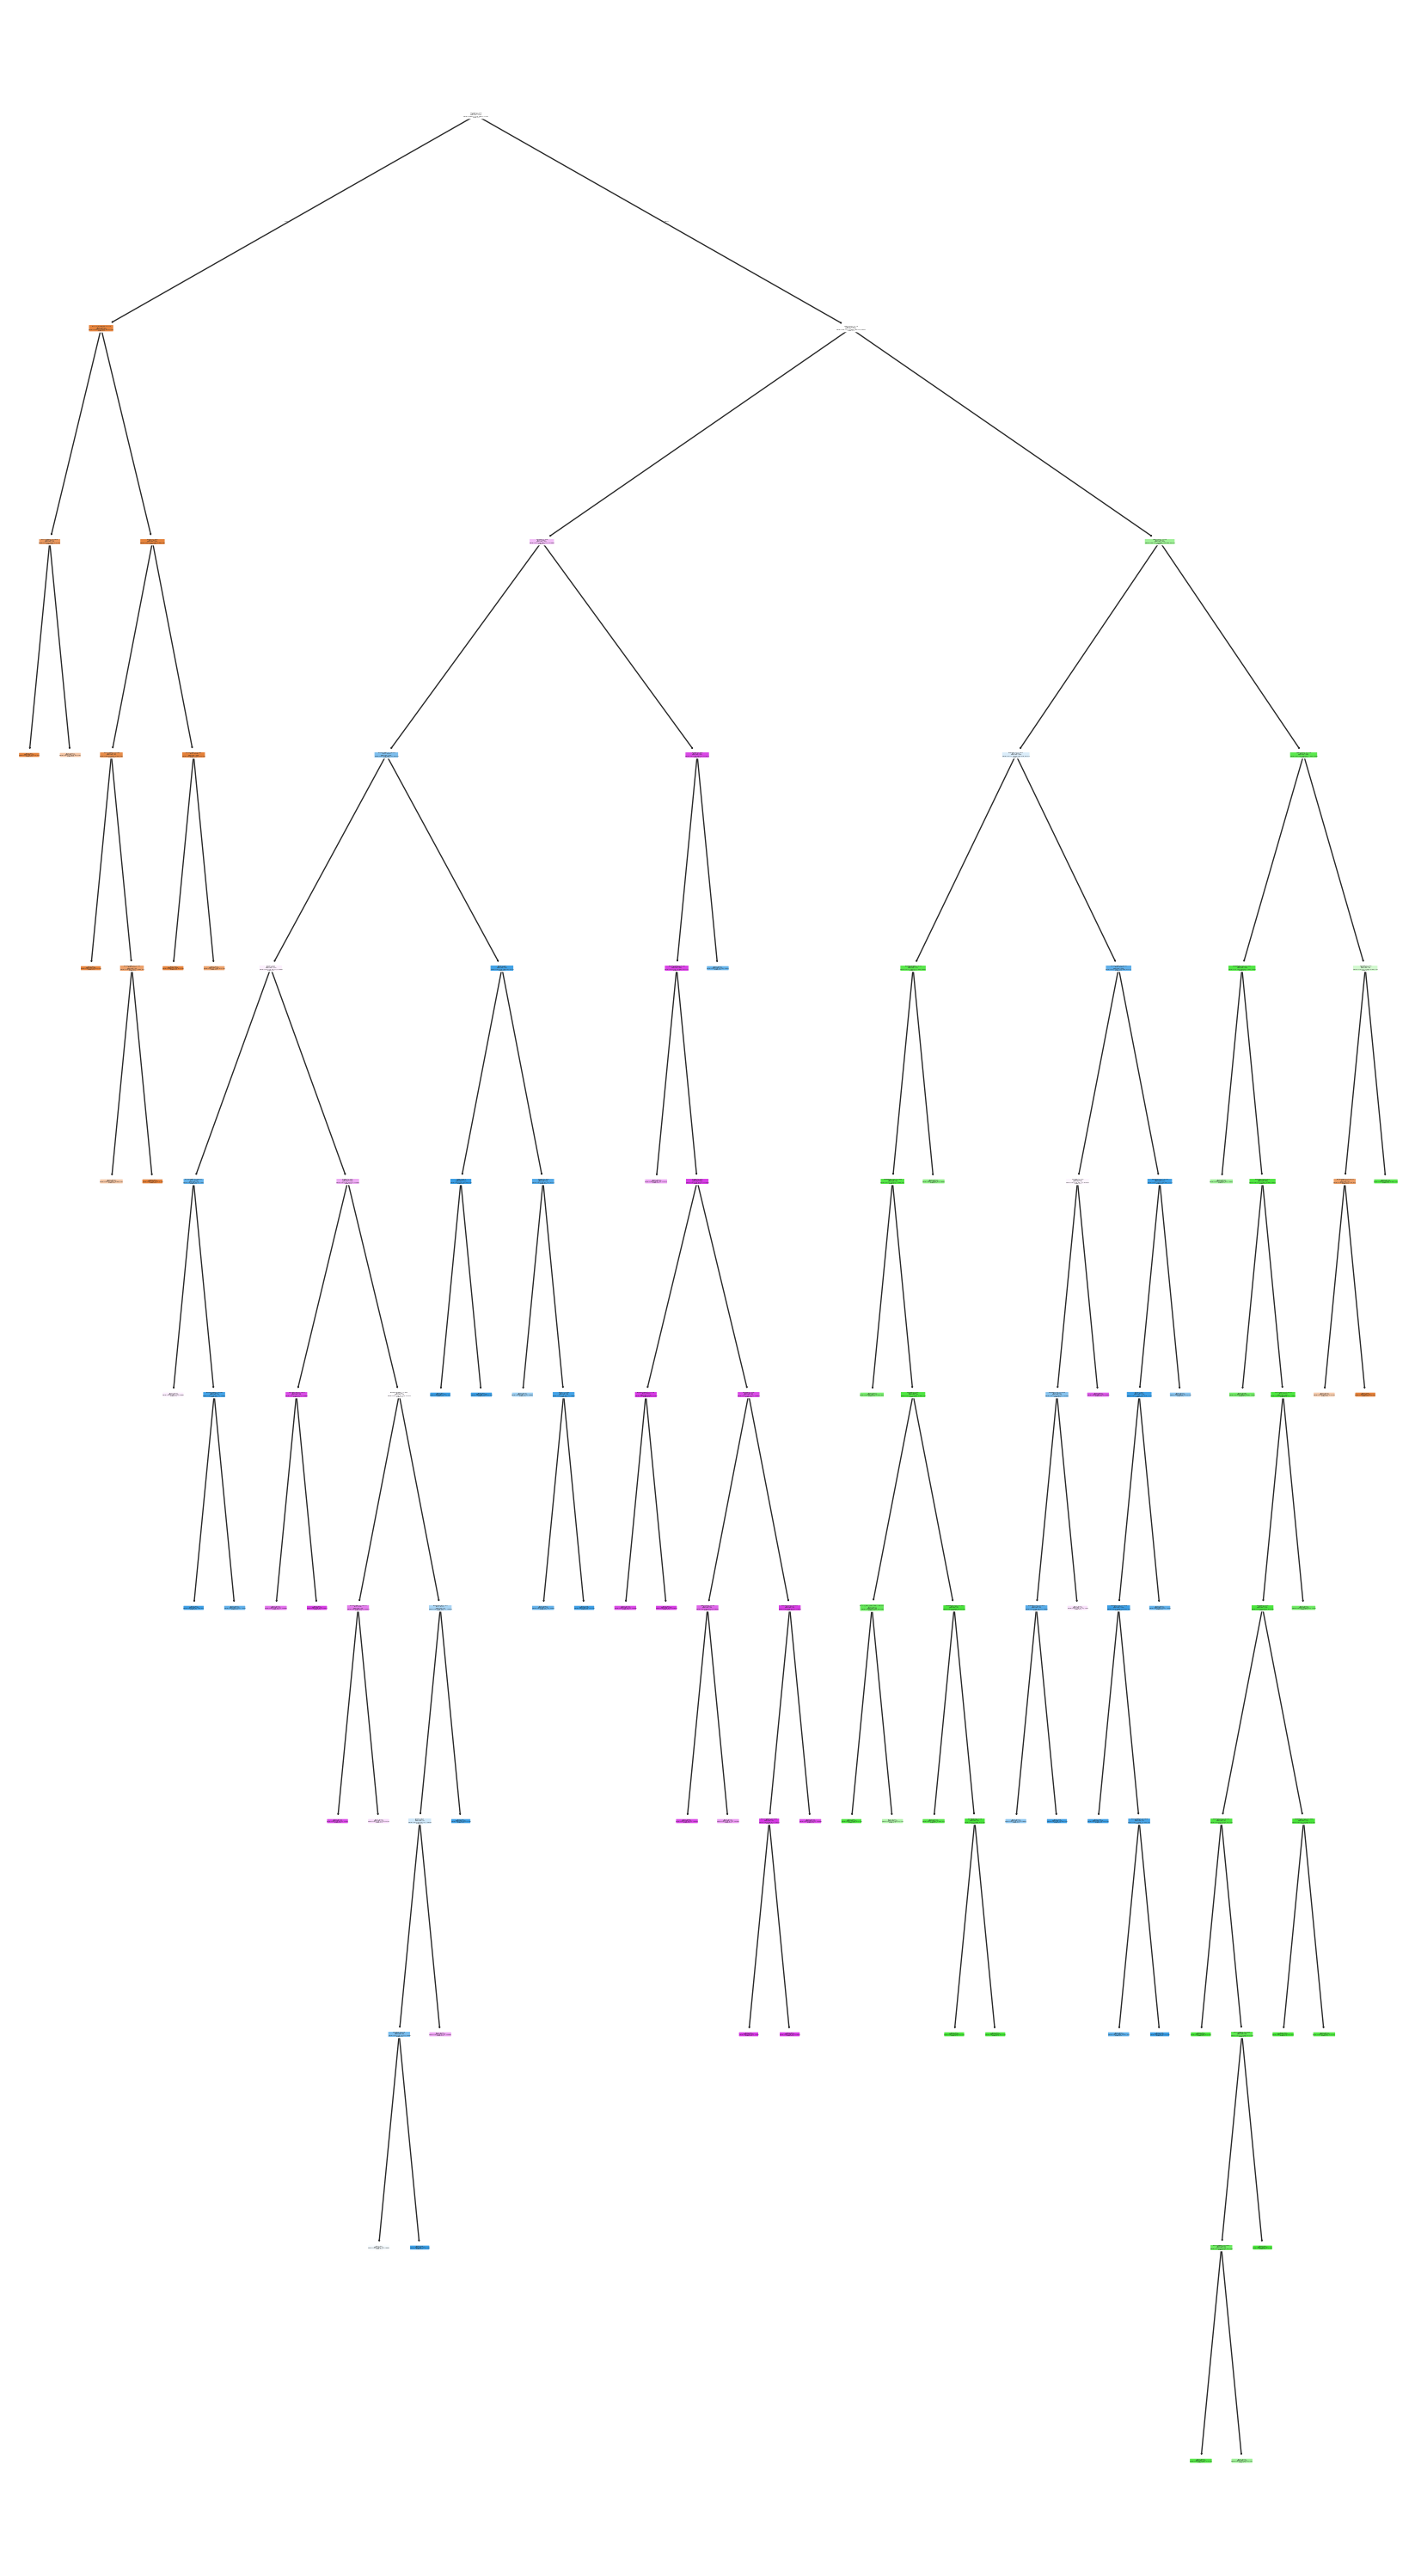

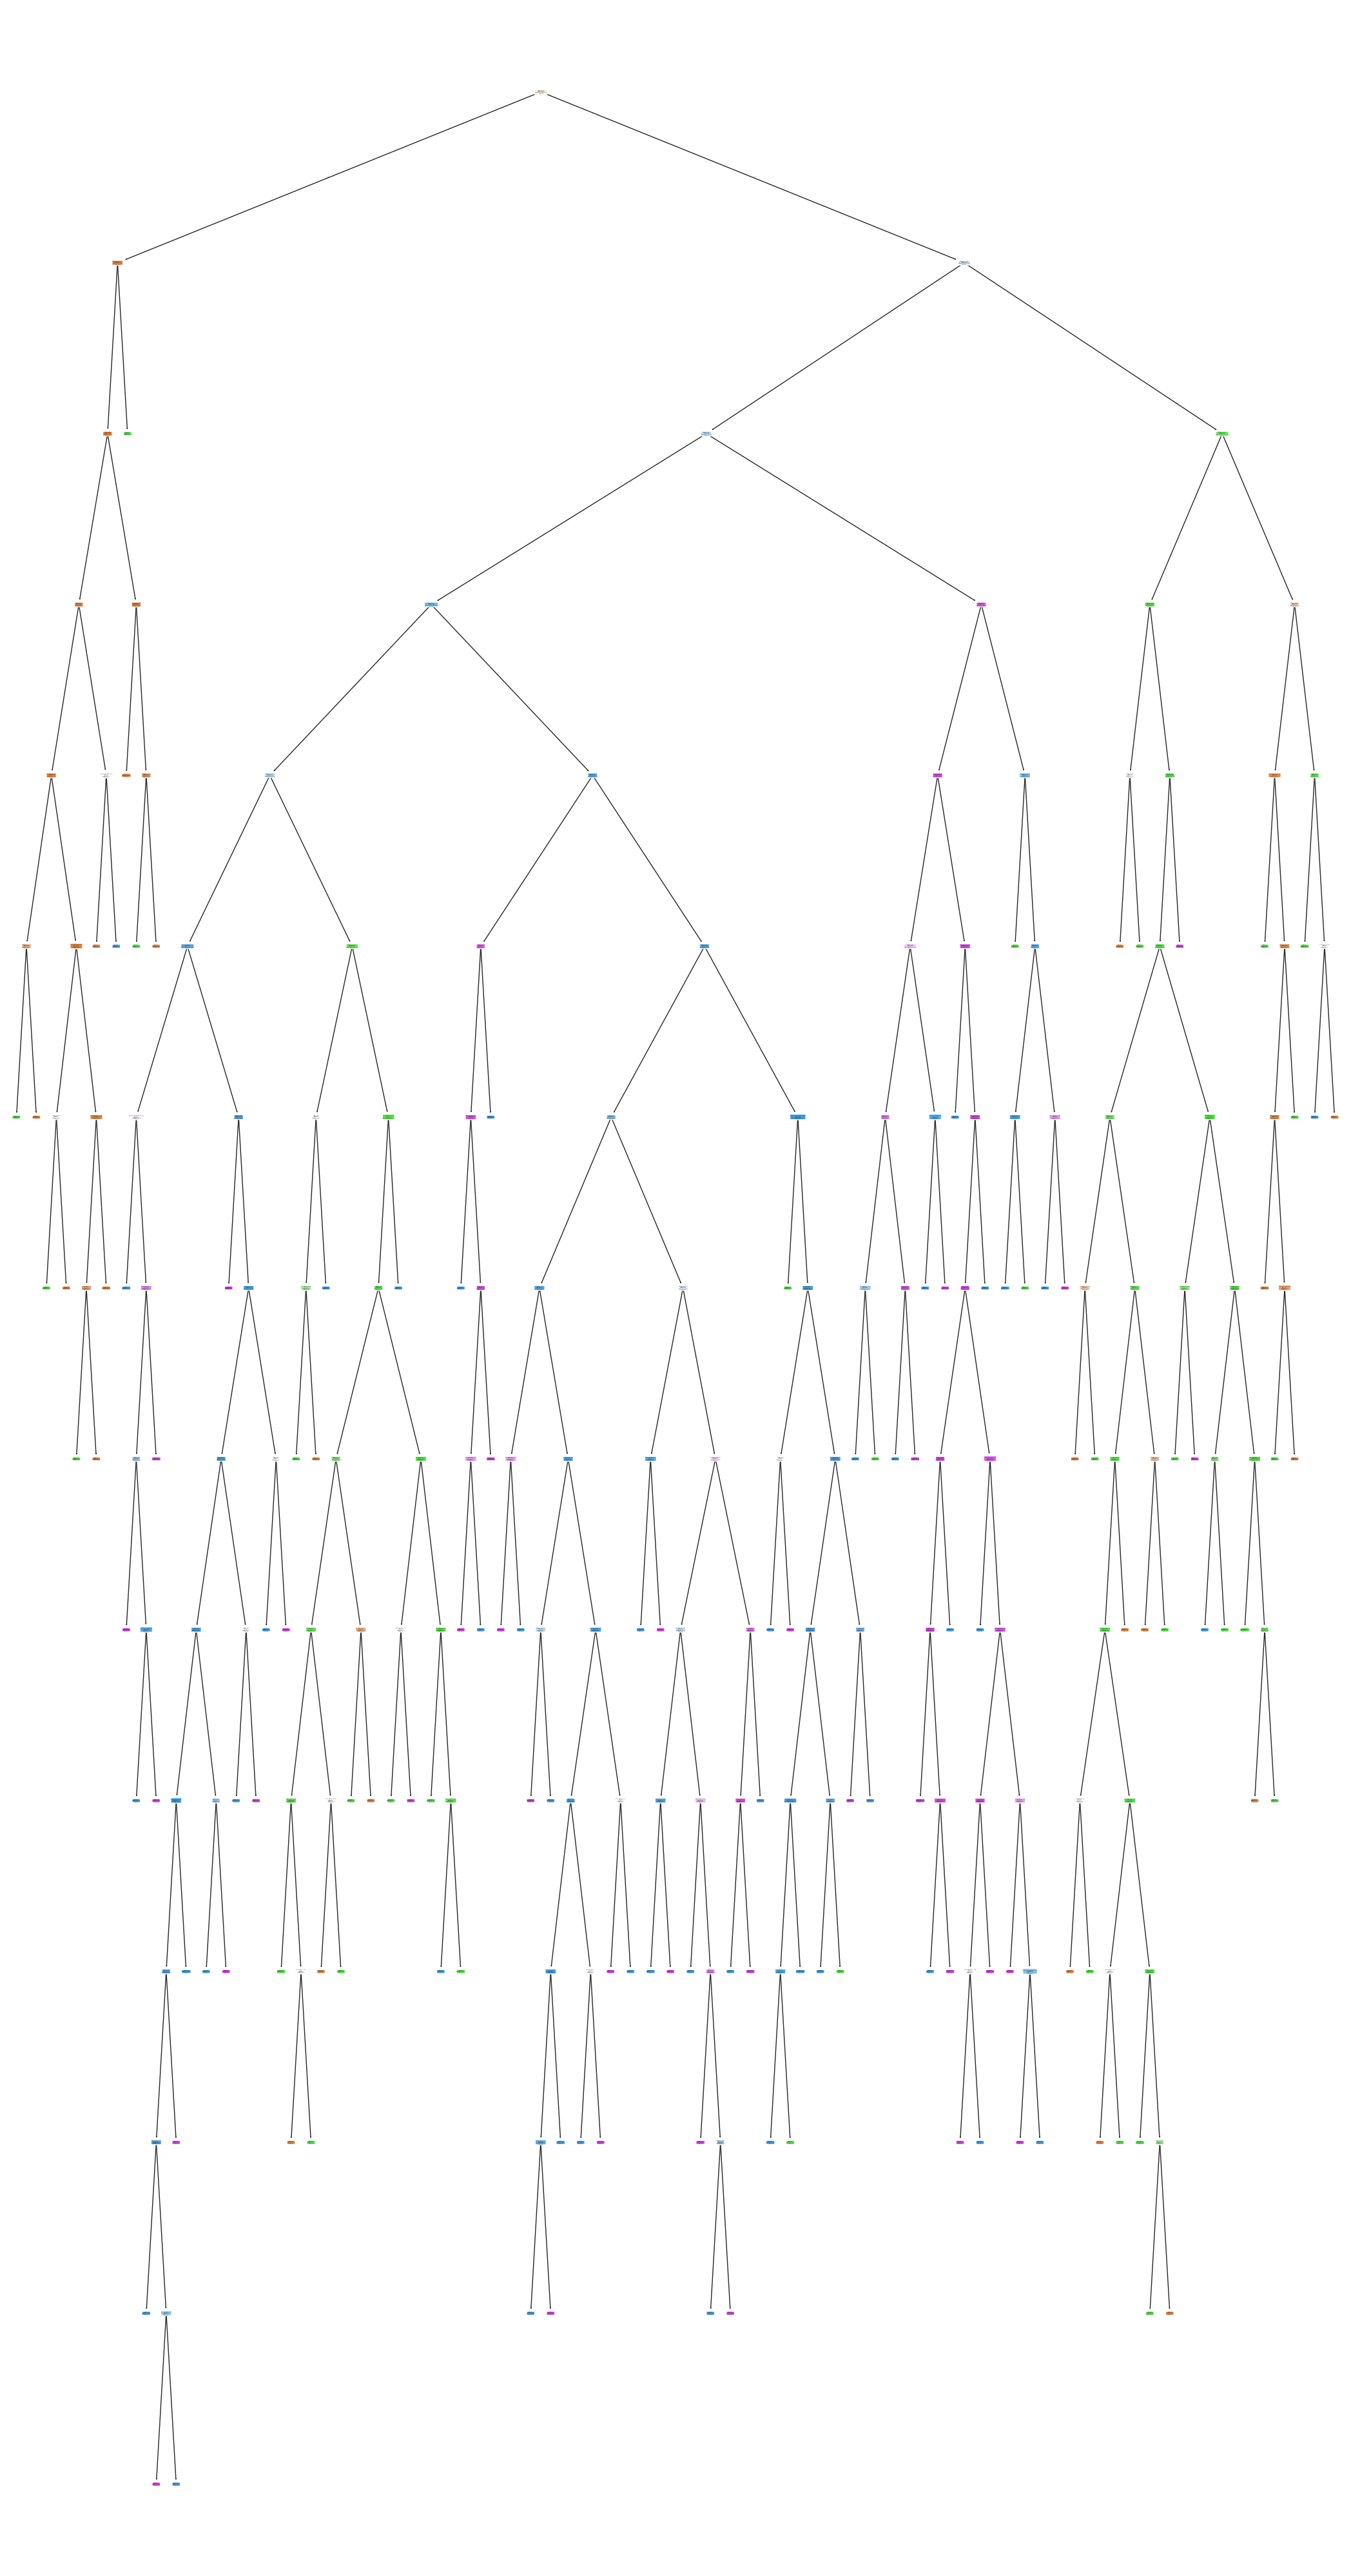

In [11]:
classifier = ADNIClassifier(classifier="XAI1")
result_df_3, per_class_df_3 = classifier.fit_evaluate_store_models(X_train, y_train, output_dir="../results/all_models/1_X_NS/models")
save_xai_models(X_train=X_train, y_train=y_train, models_dir="../results/all_models/1_X_NS/models")

#### Choosing the best model

... 

### Hybrid Sampling

Training & Evaluating: Decision Tree
Training & Evaluating: OptimalTree


Model  Accuracy  Balanced Accuracy  Precision (weighted)  \
0  Decision Tree  0.906000           0.906000              0.906474   
1    OptimalTree  0.877667           0.877667              0.877376   

   Recall (weighted)  F1 Score (weighted)  F1 Score (macro)  ROC AUC (macro)  
0           0.906000             0.906211          0.906211         0.967025  
1           0.877667             0.877481          0.877481         0.918444

Model  Class  Precision    Recall  F1 Score  Support
0  Decision Tree      0   0.975593  0.959333  0.967395   1500.0
1  Decision Tree      1   0.931516  0.934000  0.932756   1500.0
2  Decision Tree      2   0.845951  0.856667  0.851275   1500.0
3  Decision Tree      3   0.872836  0.874000  0.873418   1500.0
4    OptimalTree      0   0.935762  0.942000  0.938870   1500.0
5    OptimalTree      1   0.882470  0.886000  0.884232   1500.0
6    OptimalTree      2   0.834130  0.814667  0.824283   1500.0
7    OptimalTree      3   0.857143  0.868000  0.862537   1500.0

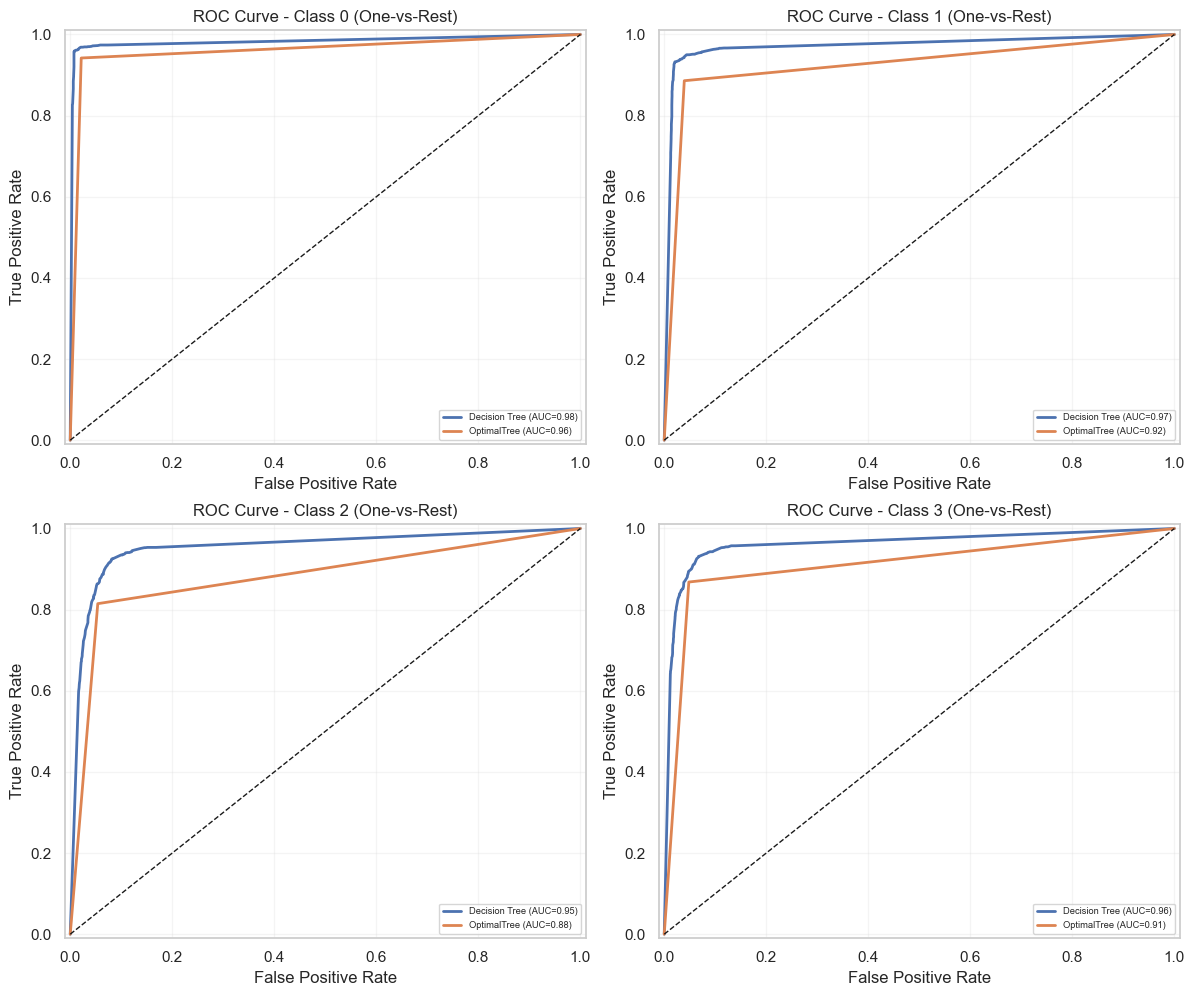

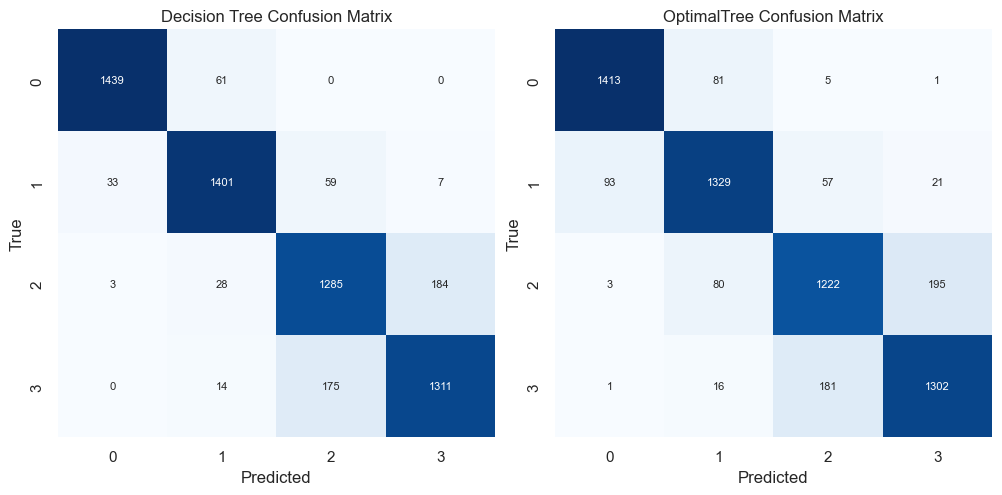

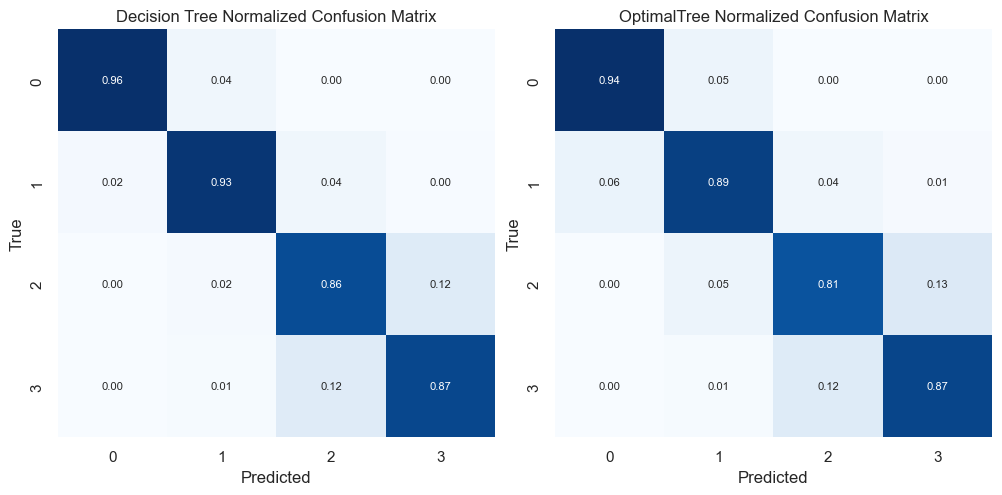

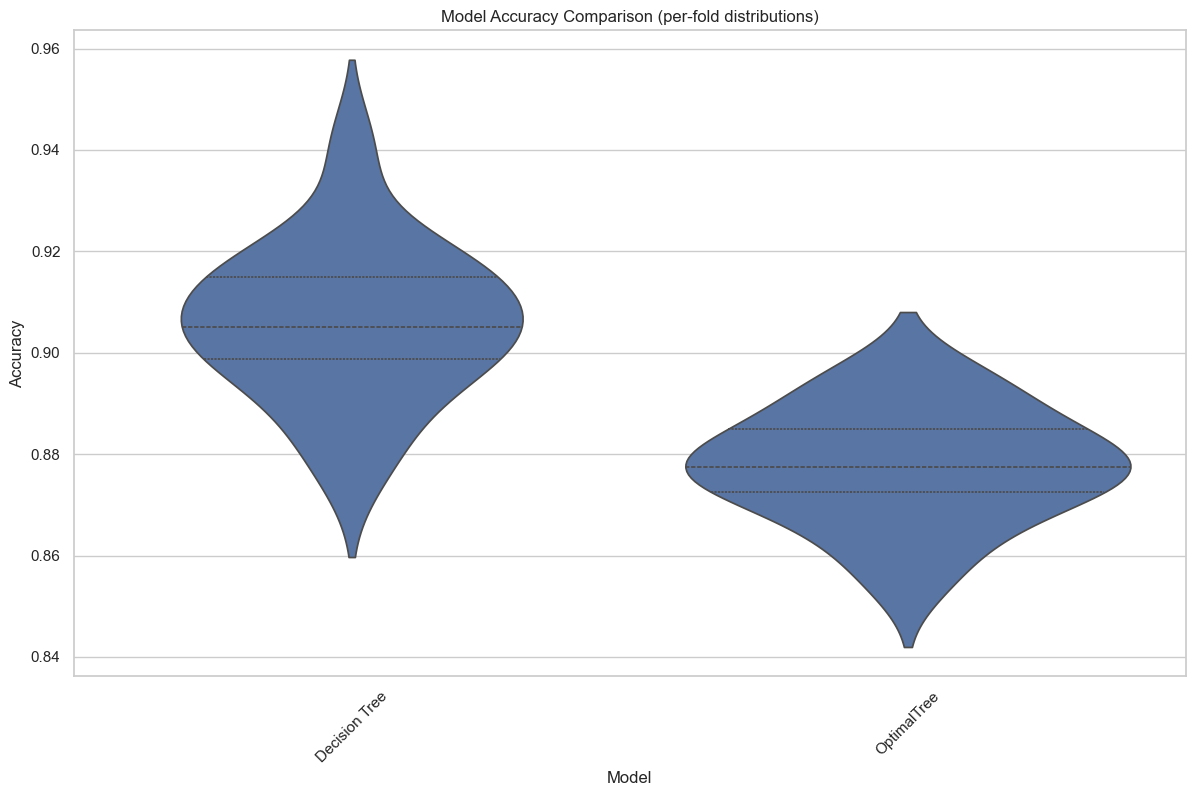

Found 2 models: ['Decision_Tree', 'OptimalTree']
Processing model: Decision_Tree
Processing model: OptimalTree
XAI outputs saved.


In [12]:
result_df_4, per_class_df_4 = classifier.fit_evaluate_store_models(X_res, y_res, output_dir="../results/all_models/1_X_S/models")
save_xai_models(X_train=X_train, y_train=y_train, models_dir="../results/all_models/1_X_S/models")

#### Choosing the best model

... 

## Dataset without `CDRSB`, `LDELTOTAL`, and `mPACCdigit` with Standard Classification

In [13]:
X_train.drop(columns=['CDRSB', 'LDELTOTAL', 'mPACCdigit'], axis=1, inplace=True)
X_res.drop(columns=['CDRSB', 'LDELTOTAL', 'mPACCdigit'], axis=1, inplace=True)

### No Sampling

Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: XGBoost
Training & Evaluating: LightGBM
Training & Evaluating: CatBoost
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: KNN
Training & Evaluating: Bagging


Model  Accuracy  Balanced Accuracy  \
2                          XGBoost  0.734057           0.694549   
4                         CatBoost  0.729231           0.685158   
1                      Extra Trees  0.737332           0.698098   
0                    Random Forest  0.725267           0.687776   
5  Multinomial Logistic Regression  0.715098           0.703750   
3                         LightGBM  0.726301           0.673688   
7                          Bagging  0.727335           0.689709   
6                              KNN  0.696829           0.632621   

   Precision (weighted)  Recall (weighted)  F1 Score (weighted)  \
2              0.721342           0.734057             0.723843   
4              0.714278           0.729231             0.715913   
1              0.725010           0.737332             0.727051   
0              0.713050           0.725267             0.716205   
5              0.719948           0.715098             0.714918   
3              0.712161           0.726301             0.706737   
7              0.718821           0.727335             0.720495   
6              0.686473           0.696829             0.668964   

   F1 Score (macro)  ROC AUC (macro)  
2          0.697532         0.917139  
4          0.687567         0.914212  
1          0.700969         0.914212  
0          0.690215         0.907189  
5          0.696083         0.905889  
3          0.675405         0.905598  
7          0.695130         0.903763  
6          0.632877         0.882005

Model  Class  Precision    Recall  F1 Score  \
0                     Random Forest      0   0.785210  0.878661  0.829311   
1                     Random Forest      1   0.506156  0.367063  0.425532   
2                     Random Forest      2   0.670219  0.688564  0.679268   
3                     Random Forest      3   0.836923  0.816817  0.826748   
4                       Extra Trees      0   0.792819  0.893073  0.839965   
5                       Extra Trees      1   0.539474  0.366071  0.436170   
6                       Extra Trees      2   0.675377  0.707421  0.691028   
7                       Extra Trees      3   0.847893  0.825826  0.836714   
8                           XGBoost      0   0.784836  0.890284  0.834241   
9                           XGBoost      1   0.522923  0.362103  0.427902   
10                          XGBoost      2   0.682970  0.704988  0.693804   
11                          XGBoost      3   0.847983  0.820821  0.834181   
12                         LightGBM      0   0.760760  0.912134  0.829598   
13                         LightGBM      1   0.547368  0.257937  0.350641   
14                         LightGBM      2   0.650163  0.726886  0.686387   
15                         LightGBM      3   0.875824  0.797798  0.834992   
16                         CatBoost      0   0.779613  0.899582  0.835312   
17                         CatBoost      1   0.512821  0.317460  0.392157   
18                         CatBoost      2   0.663037  0.703771  0.682797   
19                         CatBoost      3   0.861199  0.819820  0.840000   
20  Multinomial Logistic Regression      0   0.818140  0.830311  0.824181   
21  Multinomial Logistic Regression      1   0.463185  0.536706  0.497243   
22  Multinomial Logistic Regression      2   0.709414  0.582117  0.639492   
23  Multinomial Logistic Regression      3   0.784936  0.865866  0.823417   
24                              KNN      0   0.705800  0.933519  0.803843   
25                              KNN      1   0.573066  0.198413  0.294768   
26                              KNN      2   0.636260  0.678832  0.656857   
27                              KNN      3   0.841920  0.719720  0.776039   
28                          Bagging      0   0.794393  0.869363  0.830189   
29                          Bagging      1   0.495425  0.375992  0.427524   
30                          Bagging      2   0.661765  0.711679  0.685815   
31                          Bagging      3   0.875410  0.801802  0.836991   

    Support  
0    2151.0  
1    1008.0  
2    1644.0  
3     999.0  
4    2151.0  
5    1008.0  
6    1644.0  
7     999.0  
8    2151.0  
9    1008.0  
10   1644.0  
11    999.0  
12   2151.0  
13   1008.0  
14   1644.0  
15    999.0  
16   2151.0  
17   1008.0  
18   1644.0  
19    999.0  
20   2151.0  
21   1008.0  
22   1644.0  
23    999.0  
24   2151.0  
25   1008.0  
26   1644.0  
27    999.0  
28   2151.0  
29   1008.0  
30   1644.0  
31    999.0

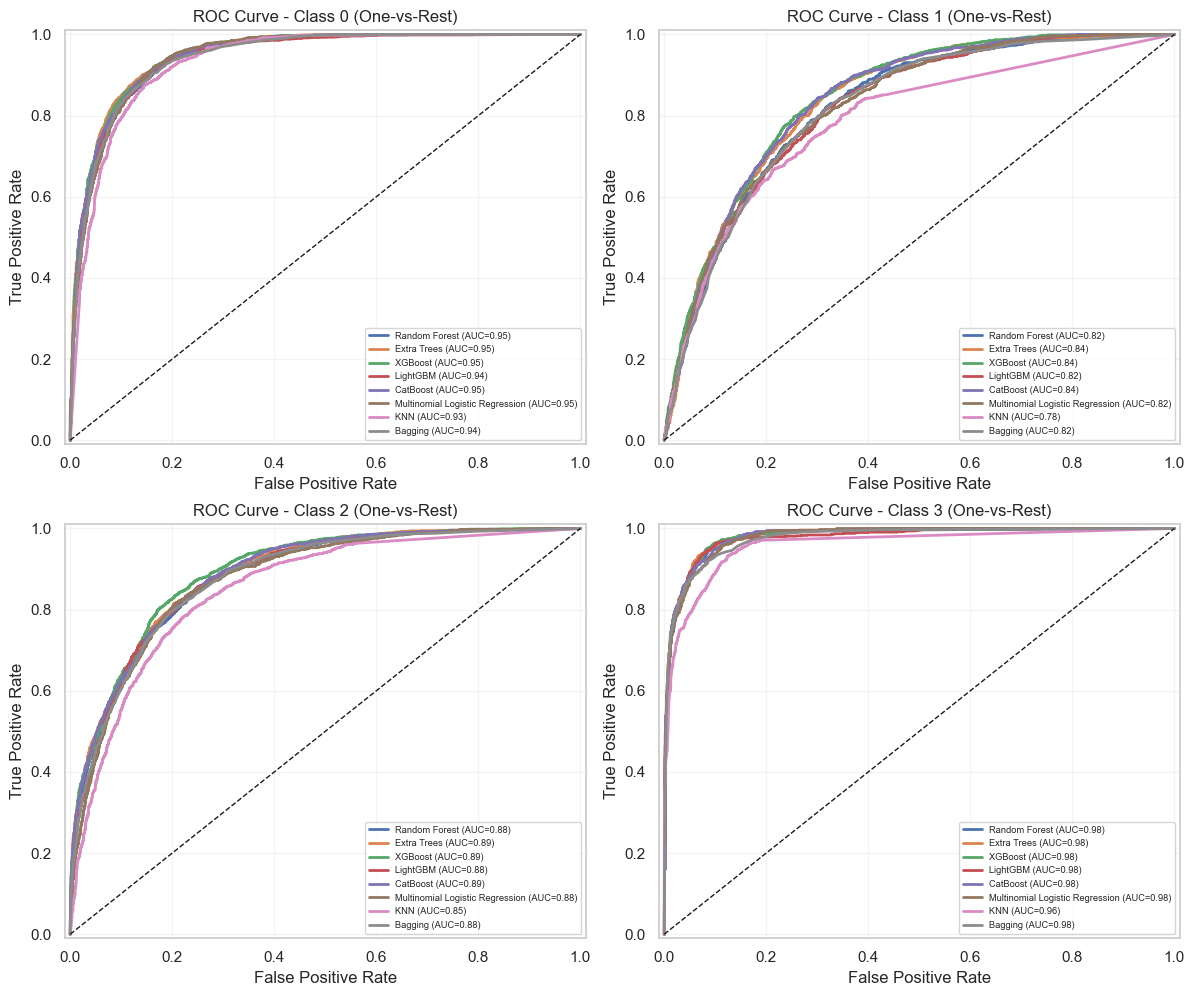

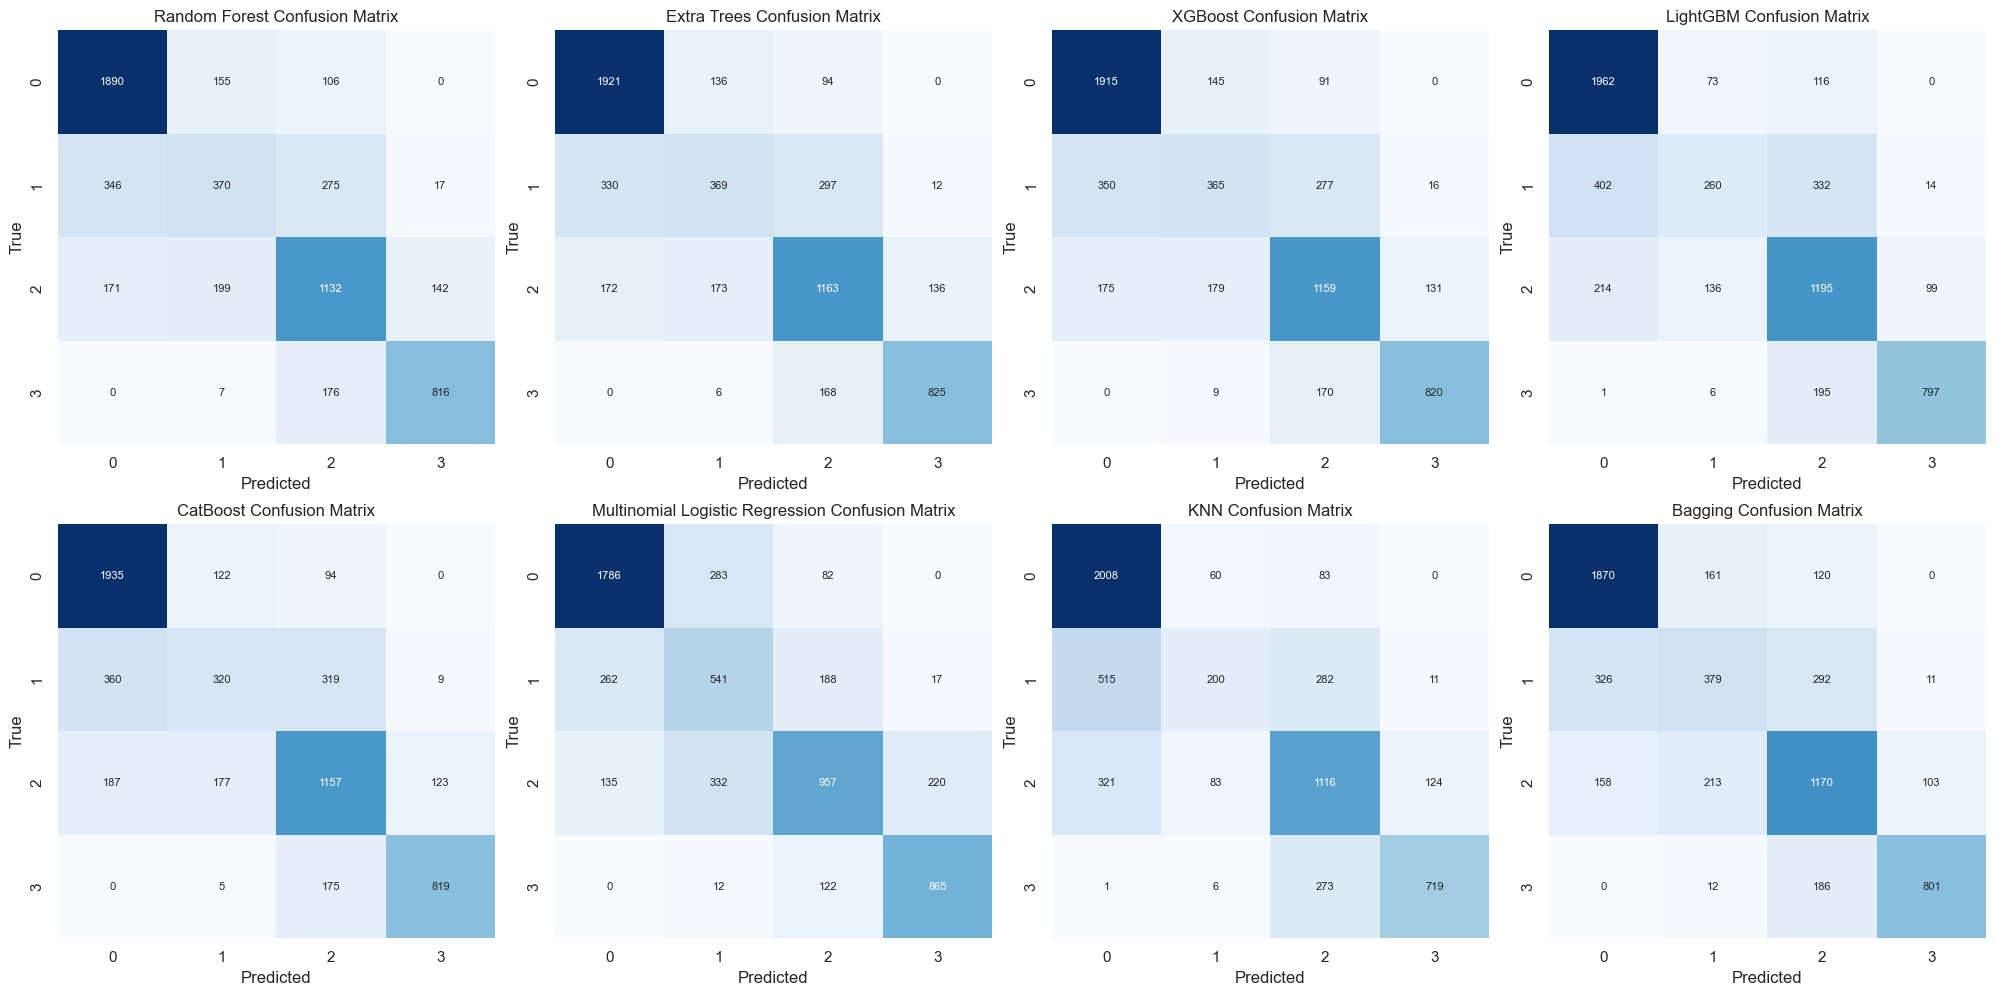

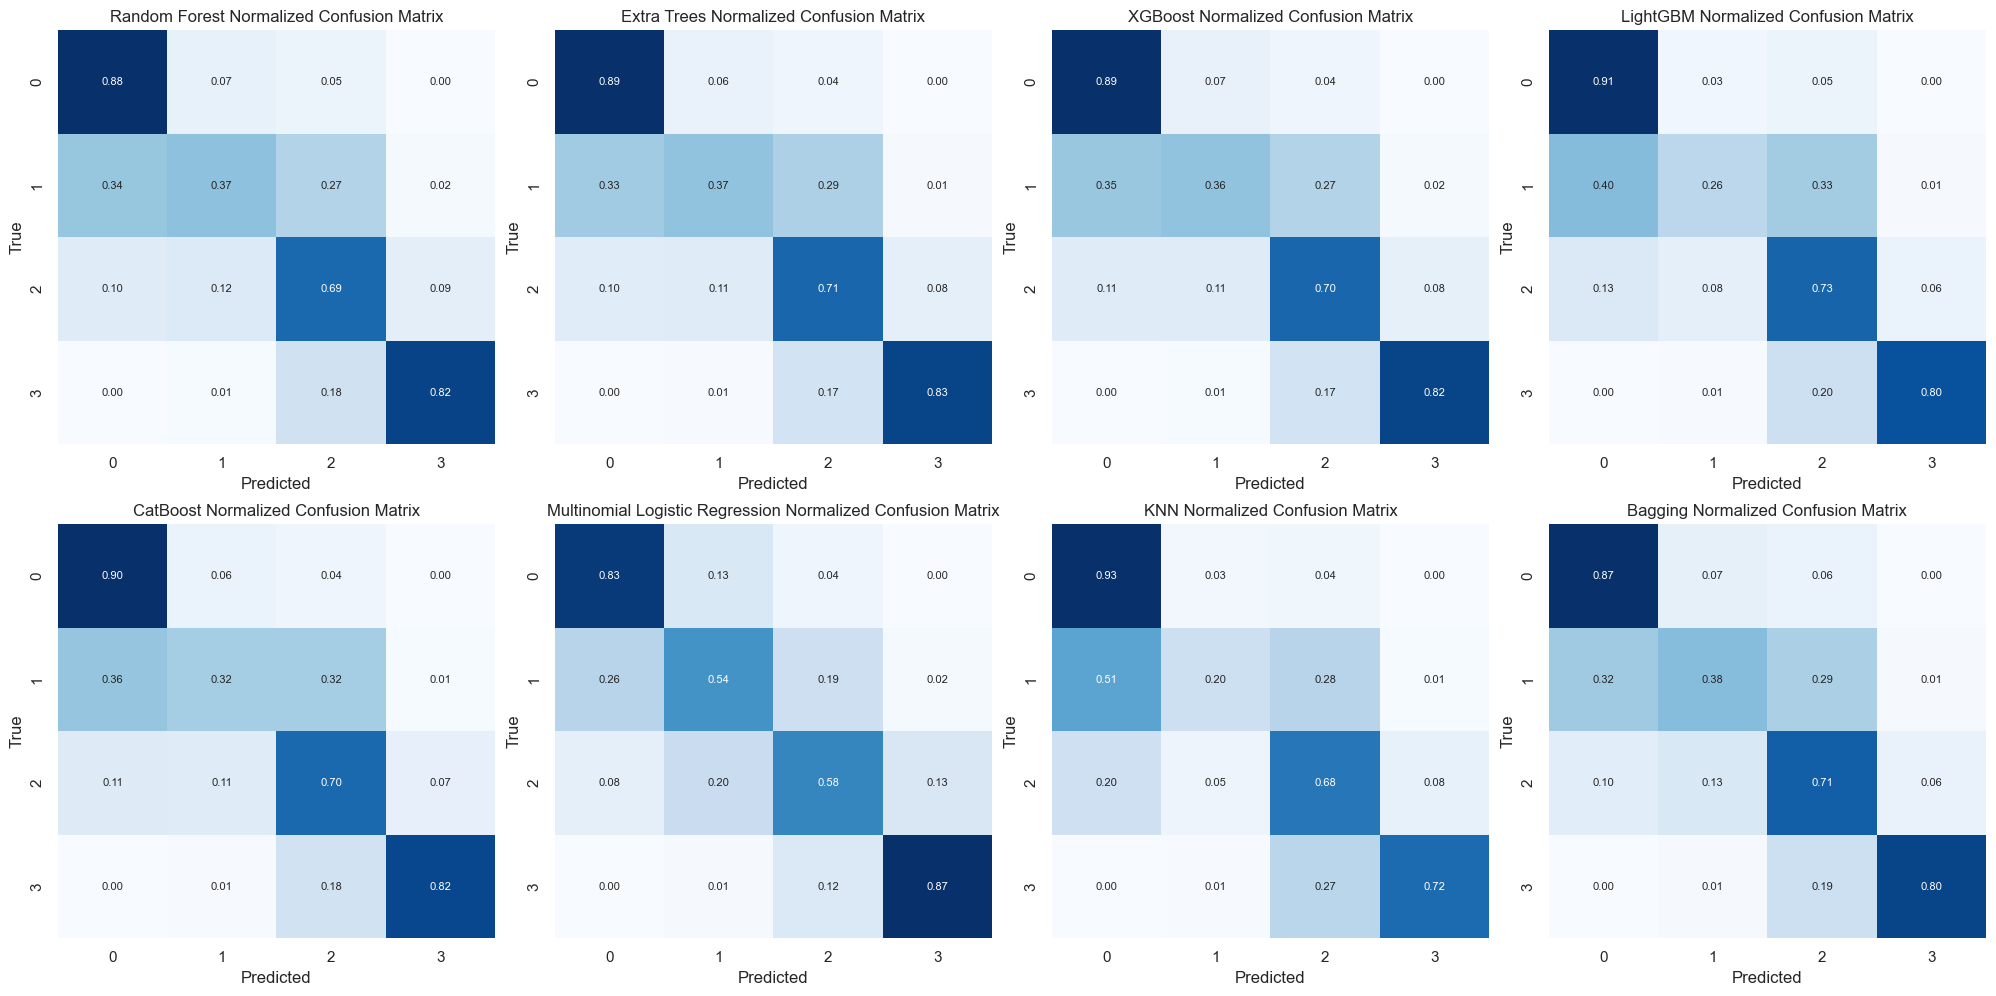

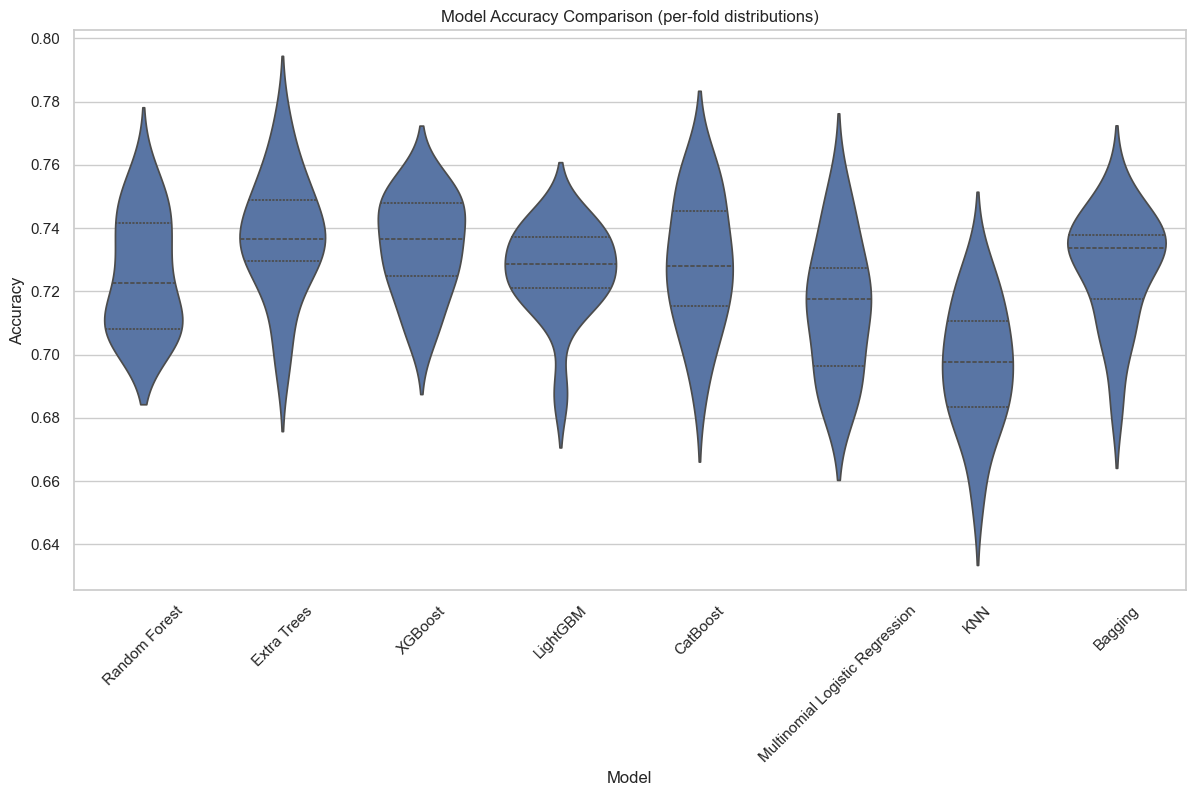

In [14]:
classifier = ADNIClassifier(classifier="Standard2")
result_df_5, per_class_df_5 = classifier.fit_evaluate_store_models(X_train, y_train, output_dir="../results/all_models/2_NX_NS")

#### Choosing the best model

...

### Hybrid Sampling

Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: XGBoost
Training & Evaluating: LightGBM
Training & Evaluating: CatBoost
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: KNN
Training & Evaluating: Bagging


Model  Accuracy  Balanced Accuracy  \
1                      Extra Trees  0.766833           0.766833   
0                    Random Forest  0.757333           0.757333   
2                          XGBoost  0.754000           0.754000   
4                         CatBoost  0.751000           0.751000   
7                          Bagging  0.752500           0.752500   
6                              KNN  0.733333           0.733333   
3                         LightGBM  0.732667           0.732667   
5  Multinomial Logistic Regression  0.723000           0.723000   

   Precision (weighted)  Recall (weighted)  F1 Score (weighted)  \
1              0.764287           0.766833             0.764840   
0              0.755012           0.757333             0.755268   
2              0.751636           0.754000             0.752310   
4              0.748539           0.751000             0.748897   
7              0.751317           0.752500             0.750989   
6              0.729546           0.733333             0.726441   
3              0.730043           0.732667             0.730664   
5              0.719413           0.723000             0.720185   

   F1 Score (macro)  ROC AUC (macro)  
1          0.764840         0.936700  
0          0.755268         0.930885  
2          0.752310         0.929667  
4          0.748897         0.929478  
7          0.750989         0.926980  
6          0.726441         0.917713  
3          0.730664         0.917182  
5          0.720185         0.915425

Model  Class  Precision    Recall  F1 Score  \
0                     Random Forest      0   0.777919  0.817333  0.797139   
1                     Random Forest      1   0.658900  0.678667  0.668637   
2                     Random Forest      2   0.703255  0.619333  0.658632   
3                     Random Forest      3   0.879974  0.914000  0.896664   
4                       Extra Trees      0   0.787650  0.833333  0.809848   
5                       Extra Trees      1   0.682237  0.691333  0.686755   
6                       Extra Trees      2   0.704833  0.632000  0.666432   
7                       Extra Trees      3   0.882429  0.910667  0.896325   
8                           XGBoost      0   0.774577  0.824667  0.798838   
9                           XGBoost      1   0.663545  0.661333  0.662437   
10                          XGBoost      2   0.687455  0.632000  0.658562   
11                          XGBoost      3   0.880968  0.898000  0.889402   
12                         LightGBM      0   0.744785  0.809333  0.775719   
13                         LightGBM      1   0.623051  0.612667  0.617815   
14                         LightGBM      2   0.672993  0.614667  0.642509   
15                         LightGBM      3   0.879344  0.894000  0.886612   
16                         CatBoost      0   0.764378  0.824000  0.793070   
17                         CatBoost      1   0.652980  0.657333  0.655150   
18                         CatBoost      2   0.695131  0.618667  0.654674   
19                         CatBoost      3   0.881664  0.904000  0.892693   
20  Multinomial Logistic Regression      0   0.730632  0.817333  0.771554   
21  Multinomial Logistic Regression      1   0.639379  0.604000  0.621186   
22  Multinomial Logistic Regression      2   0.643945  0.592000  0.616881   
23  Multinomial Logistic Regression      3   0.863696  0.878667  0.871117   
24                              KNN      0   0.711391  0.866000  0.781118   
25                              KNN      1   0.686730  0.631333  0.657867   
26                              KNN      2   0.696137  0.540667  0.608630   
27                              KNN      3   0.823926  0.895333  0.858147   
28                          Bagging      0   0.771061  0.799333  0.784943   
29                          Bagging      1   0.650063  0.687333  0.668179   
30                          Bagging      2   0.700303  0.615333  0.655075   
31                          Bagging      3   0.883842  0.908000  0.895758   

    Support  
0    1500.0  
1    1500.0  
2    1500.0  
3    1500.0  
4    1500.0  
5    1500.0  
6    1500.0  
7    1500.0  
8    1500.0  
9    1500.0  
10   1500.0  
11   1500.0  
12   1500.0  
13   1500.0  
14   1500.0  
15   1500.0  
16   1500.0  
17   1500.0  
18   1500.0  
19   1500.0  
20   1500.0  
21   1500.0  
22   1500.0  
23   1500.0  
24   1500.0  
25   1500.0  
26   1500.0  
27   1500.0  
28   1500.0  
29   1500.0  
30   1500.0  
31   1500.0

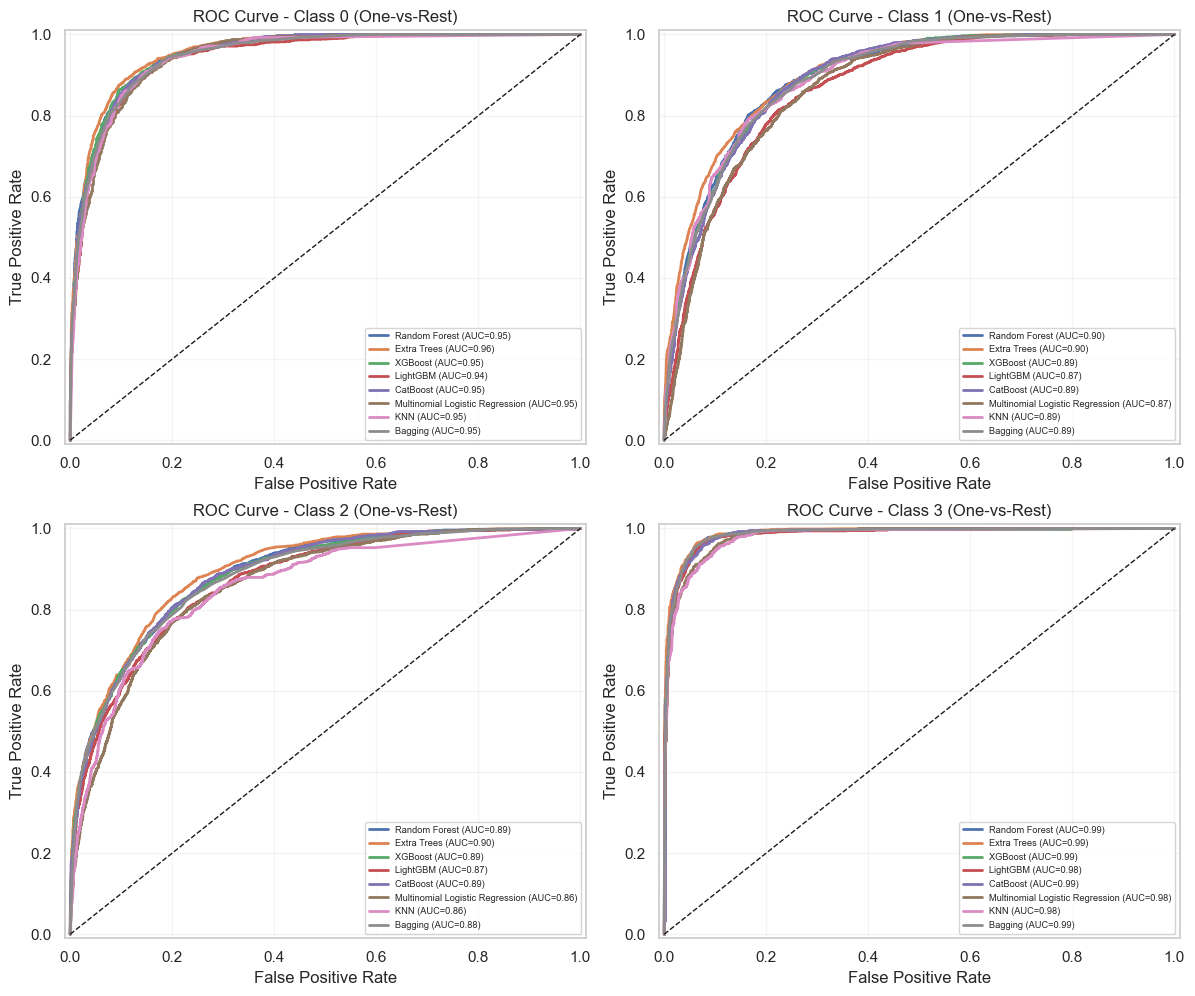

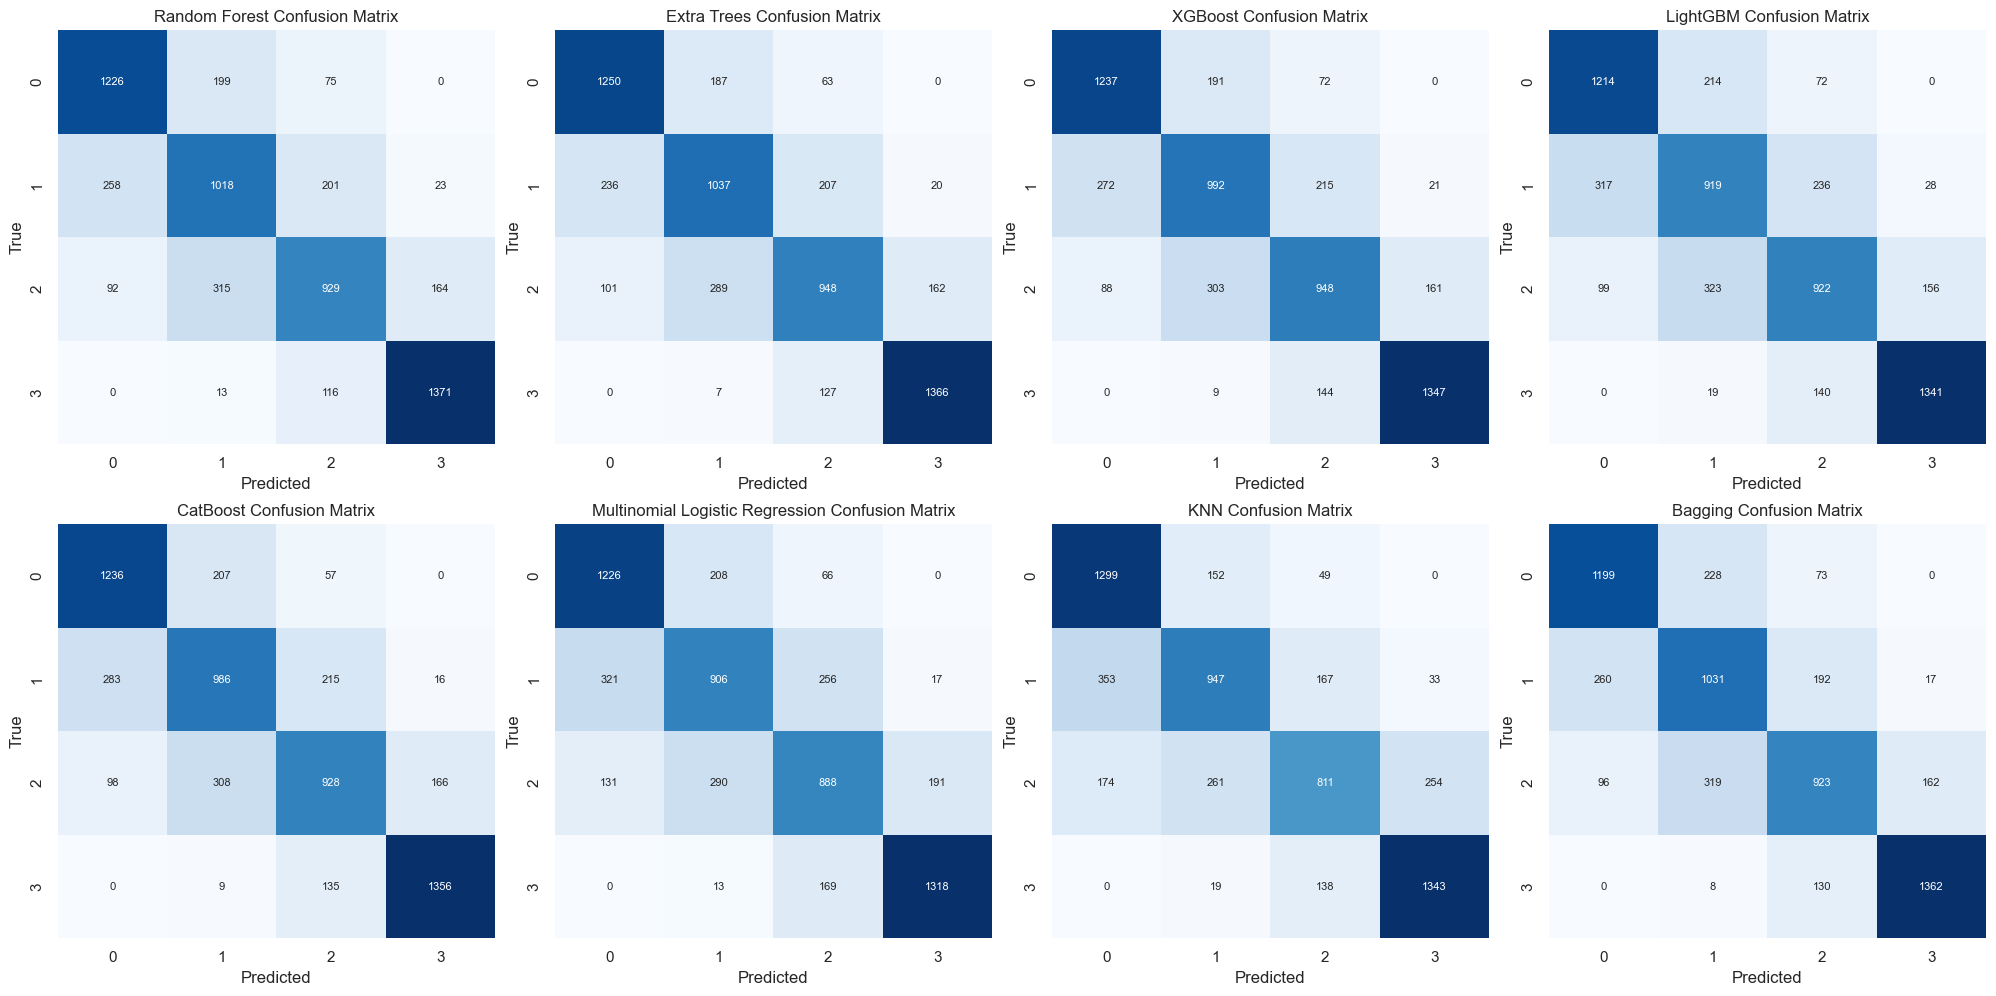

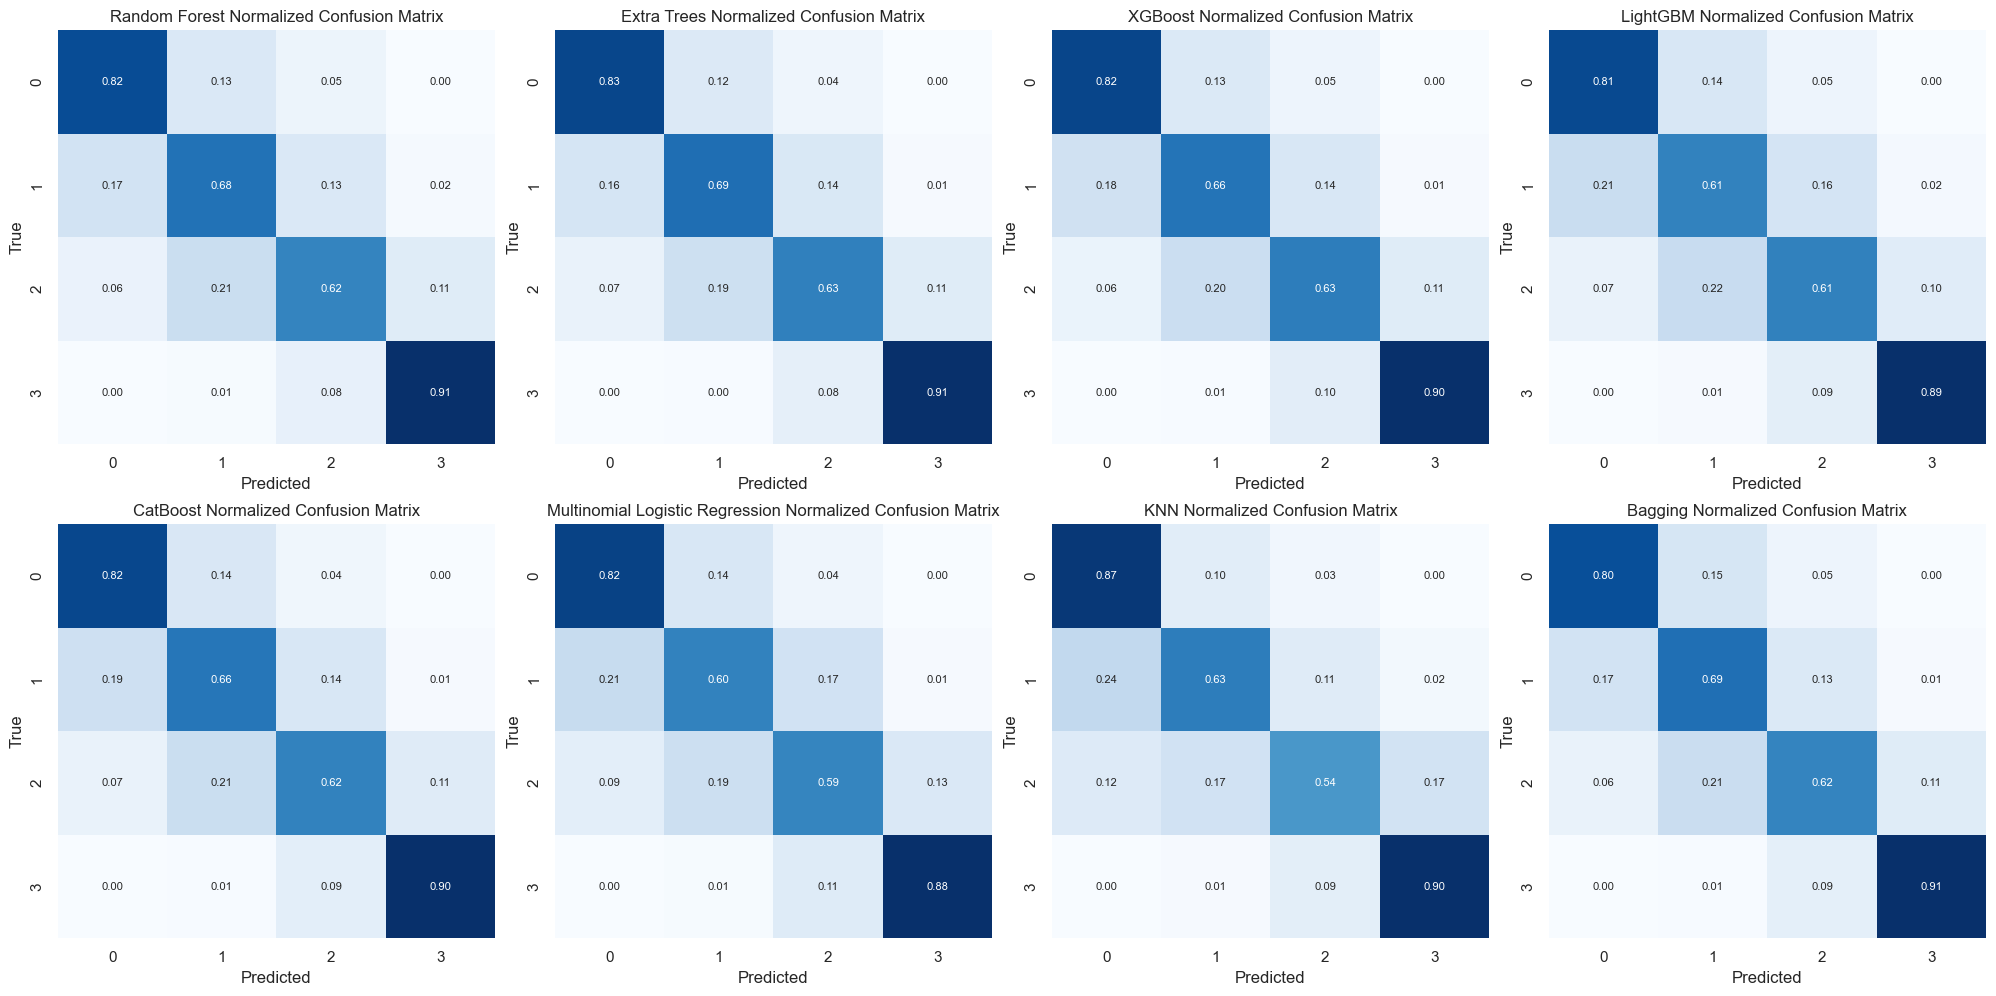

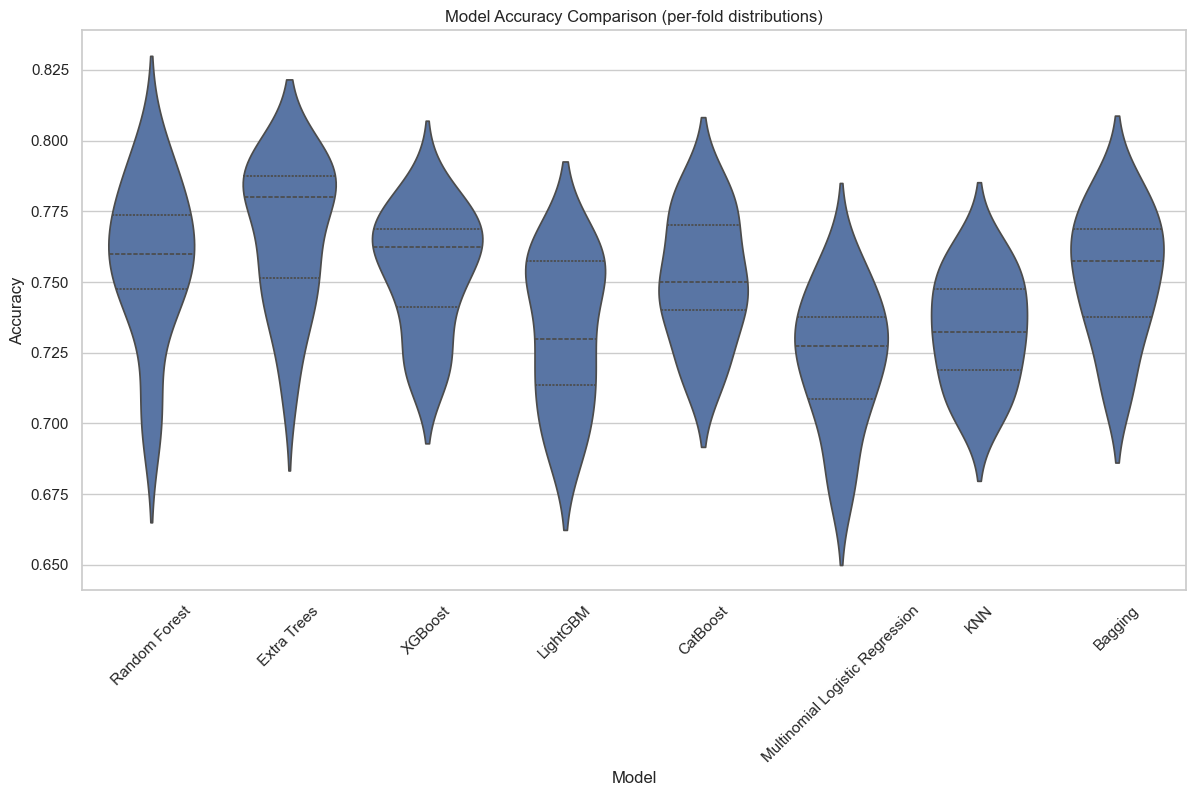

In [15]:
result_df_6, per_class_df_6 = classifier.fit_evaluate_store_models(X_res, y_res, output_dir="../results/all_models/2_NX_S")

#### Choosing the best model

...

## Dataset without `CDRSB`, `LDELTOTAL`, and `mPACCdigit` with XAI Classification

In [16]:
# X_train.drop(columns=['CDRSB', 'LDELTOTAL', 'mPACCdigit'], axis=1, inplace=True)
# X_res.drop(columns=['CDRSB', 'LDELTOTAL', 'mPACCdigit'], axis=1, inplace=True)

### No Sampling

Training & Evaluating: Decision Tree
Training & Evaluating: OptimalTree


Model  Accuracy  Balanced Accuracy  Precision (weighted)  \
0  Decision Tree  0.639607           0.634636              0.660877   
1    OptimalTree  0.638401           0.616244              0.638389   

   Recall (weighted)  F1 Score (weighted)  F1 Score (macro)  ROC AUC (macro)  
0           0.639607             0.647136          0.628222         0.833710  
1           0.638401             0.638382          0.615408         0.746434

Model  Class  Precision    Recall  F1 Score  Support
0  Decision Tree      0   0.799681  0.699675  0.746343   2151.0
1  Decision Tree      1   0.346154  0.455357  0.393316   1008.0
2  Decision Tree      2   0.617940  0.565693  0.590664   1644.0
3  Decision Tree      3   0.750230  0.817818  0.782567    999.0
4    OptimalTree      0   0.758314  0.752673  0.755483   2151.0
5    OptimalTree      1   0.362103  0.362103  0.362103   1008.0
6    OptimalTree      2   0.575426  0.575426  0.575426   1644.0
7    OptimalTree      3   0.762562  0.774775  0.768620    999.0

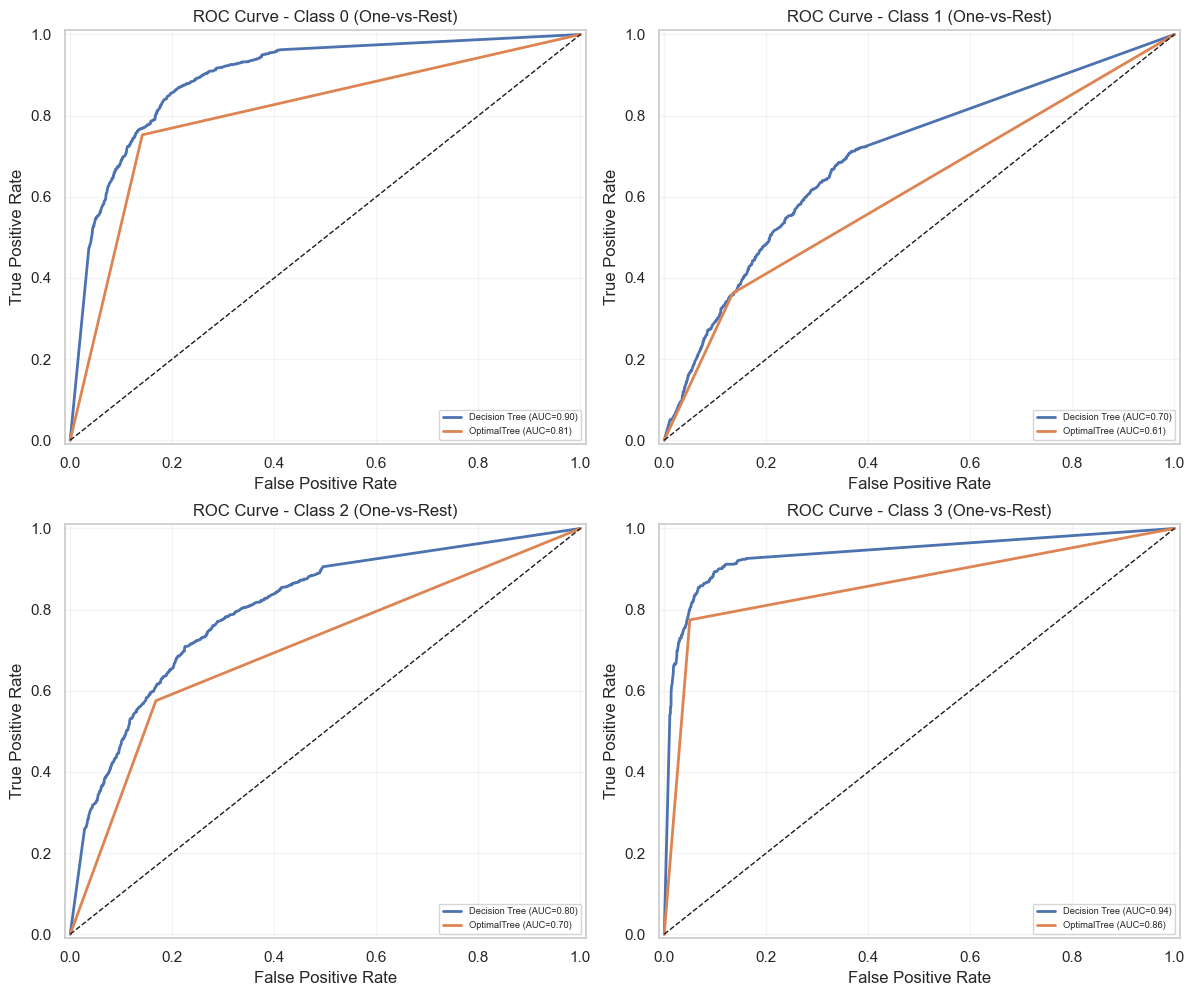

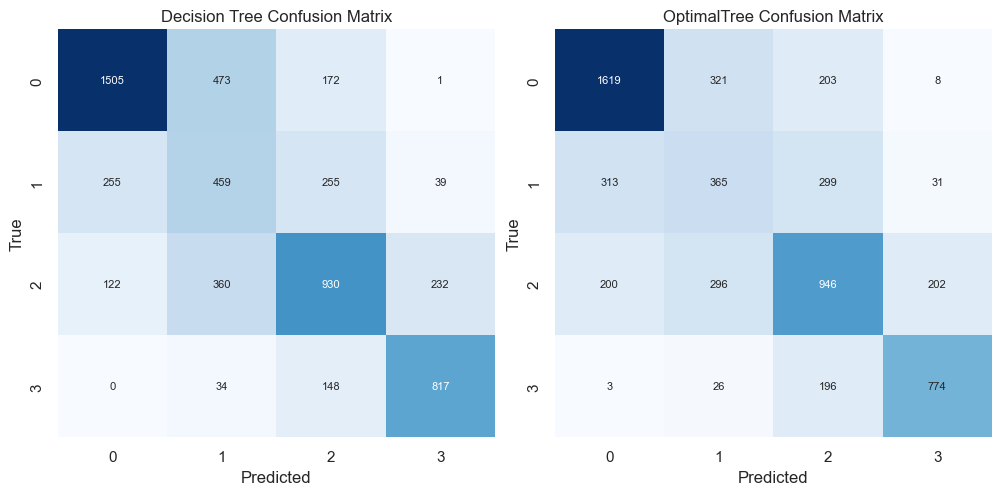

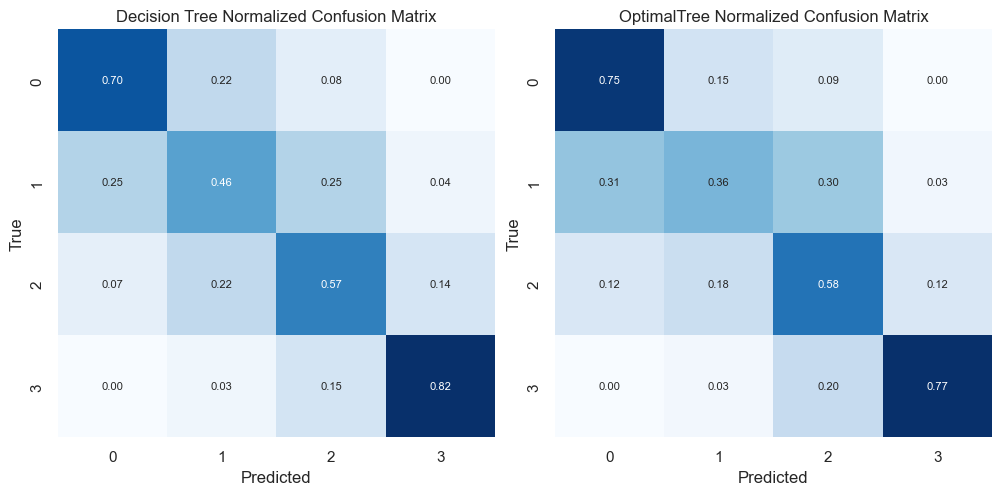

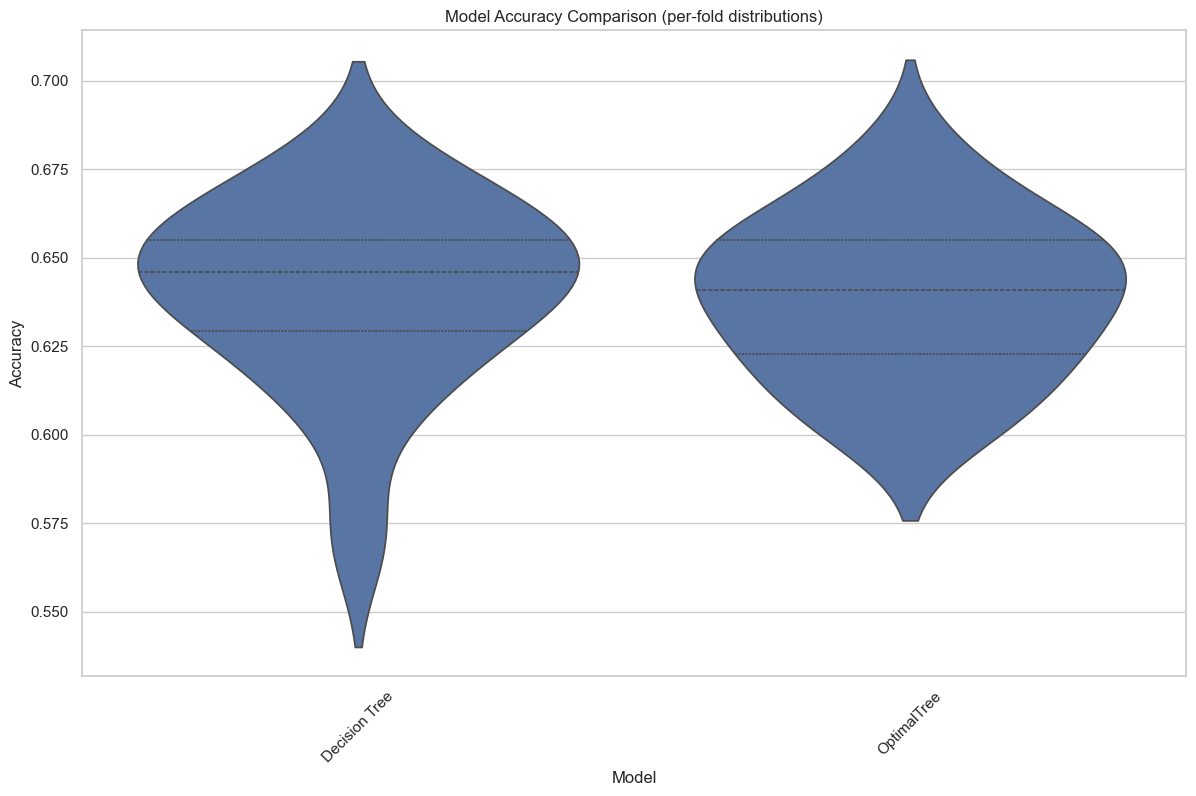

Found 2 models: ['Decision_Tree', 'OptimalTree']
Processing model: Decision_Tree
Processing model: OptimalTree
XAI outputs saved.


In [17]:
classifier = ADNIClassifier(classifier="XAI2")
result_df_7, per_class_df_7 = classifier.fit_evaluate_store_models(X_train, y_train, output_dir="../results/all_models/2_X_NS/models")
save_xai_models(X_train=X_train, y_train=y_train, models_dir="../results/all_models/2_X_NS/models")

#### Choosing the best model

... 

### Hybrid Sampling

Training & Evaluating: Decision Tree
Training & Evaluating: OptimalTree


Model  Accuracy  Balanced Accuracy  Precision (weighted)  \
0  Decision Tree  0.661500           0.661500              0.661107   
1    OptimalTree  0.658833           0.658833              0.657960   

   Recall (weighted)  F1 Score (weighted)  F1 Score (macro)  ROC AUC (macro)  
0           0.661500             0.661060          0.661060         0.849521  
1           0.658833             0.658268          0.658268         0.772556

Model  Class  Precision    Recall  F1 Score  Support
0  Decision Tree      0   0.685401  0.707333  0.696194   1500.0
1  Decision Tree      1   0.524823  0.542667  0.533596   1500.0
2  Decision Tree      2   0.578872  0.540667  0.559118   1500.0
3  Decision Tree      3   0.855333  0.855333  0.855333   1500.0
4    OptimalTree      0   0.694276  0.687333  0.690787   1500.0
5    OptimalTree      1   0.538660  0.557333  0.547837   1500.0
6    OptimalTree      2   0.554007  0.530000  0.541738   1500.0
7    OptimalTree      3   0.844895  0.860667  0.852708   1500.0

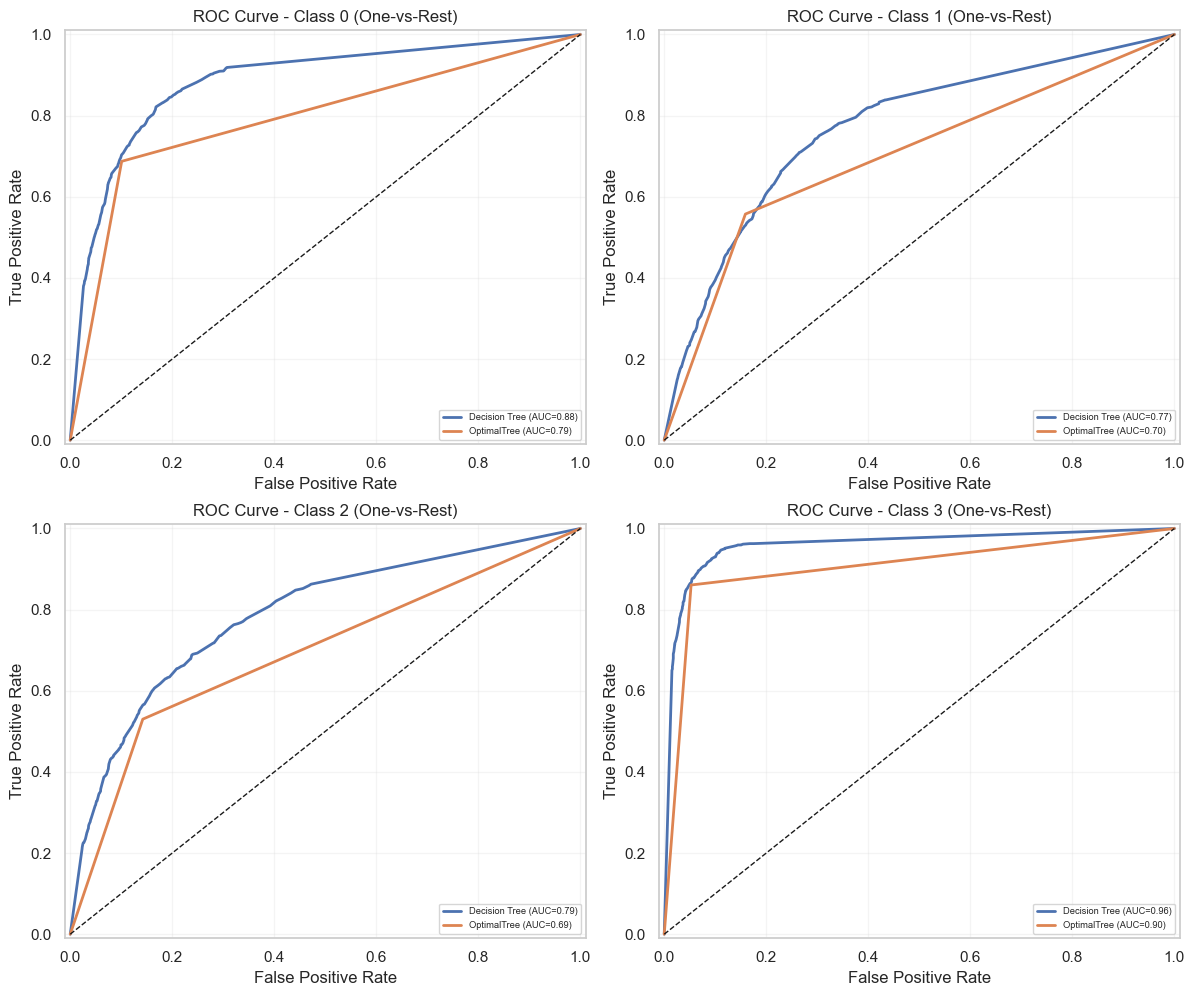

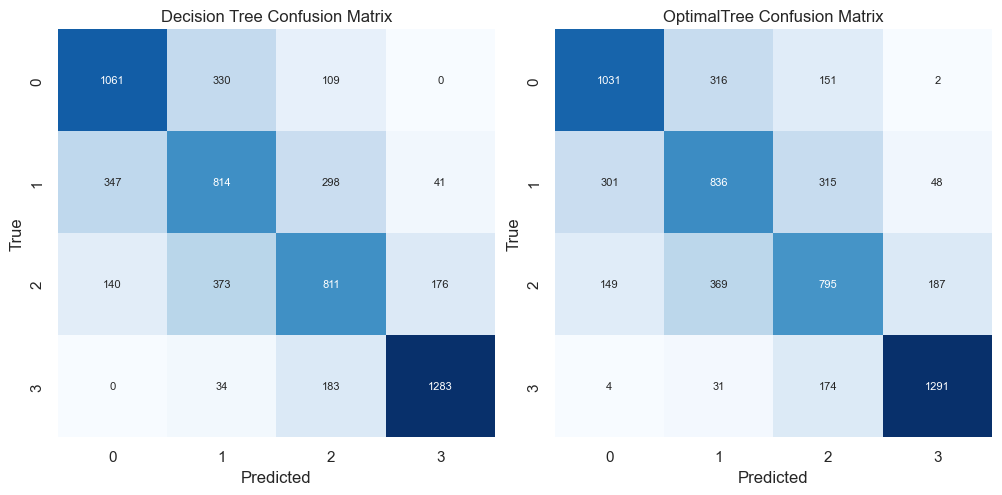

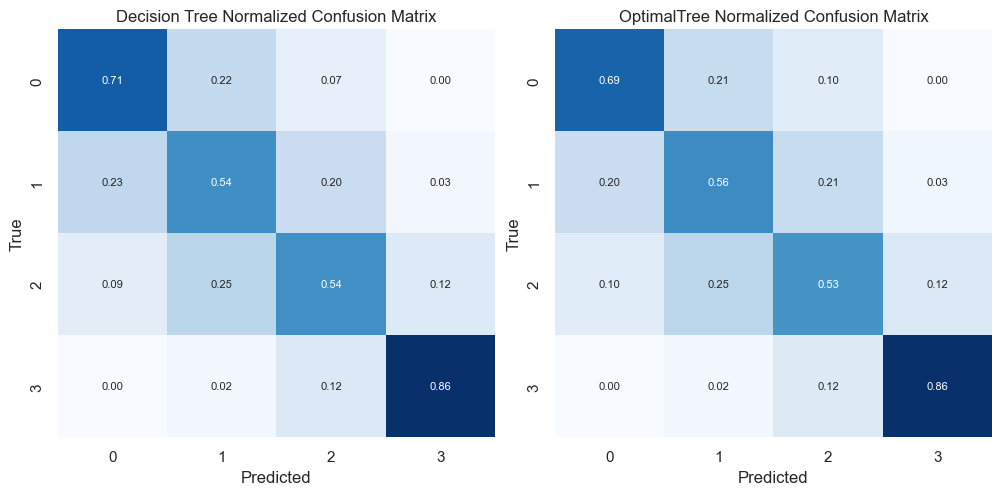

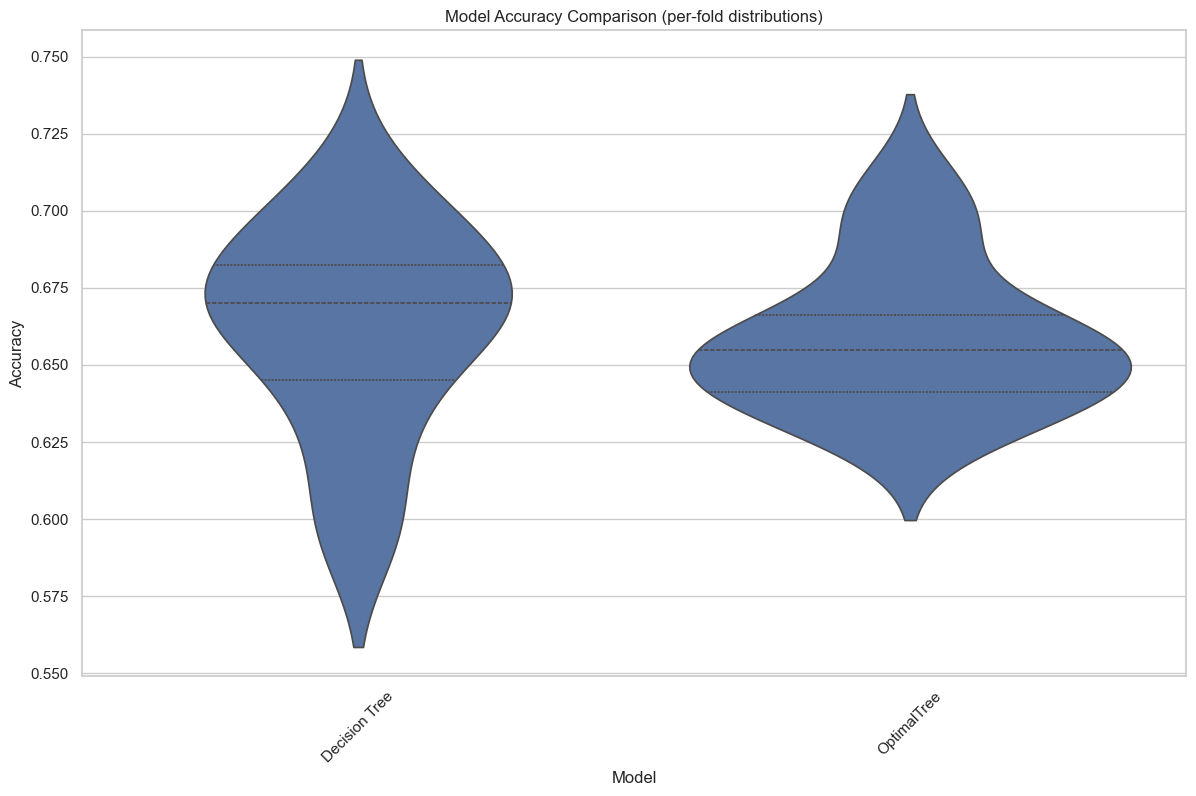

Found 2 models: ['Decision_Tree', 'OptimalTree']
Processing model: Decision_Tree
Processing model: OptimalTree
XAI outputs saved.


In [18]:
result_df_8, per_class_df_8 = classifier.fit_evaluate_store_models(X_res, y_res, output_dir="../results/all_models/2_X_S/models")
save_xai_models(X_train=X_train, y_train=y_train, models_dir="../results/all_models/2_X_S/models")

#### Choosing the best model

... 